In [ ]:
%load_ext cudf

The cudf module is not an IPython extension.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def feature_engineering_EEG(df: pd.DataFrame, i: int):
    # Step 1: Drop unwanted columns
    df.drop(["Elements", "HeadBandOn", "AUX_RIGHT", "UnixTime", "Battery"],
            axis=1, inplace=True, errors="ignore")

    # Step 2: Fill QuestionKey NaN with 'None'
    df['QuestionKey'].fillna('None', inplace=True)

    # Step 3: Convert HSI values into flags (0 = good, 1 = bad)
    signal_flags_values = {1: 0, 2: 0, 4: 1, 1.0: 0, 2.0: 0, 4.0: 1}
    for col in ['HSI_TP9','HSI_TP10','HSI_AF7','HSI_AF8']:
        flag_col = col + '_flag'
        df.loc[:, flag_col] = df[col].map(signal_flags_values).fillna(1).astype(np.int8)
    df.drop(['HSI_TP9', 'HSI_TP10', 'HSI_AF7', 'HSI_AF8'], axis=1, inplace=True, errors="ignore")

    # Step 4: Drop raw EEG channels
    raw_cols = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
    df.drop(raw_cols, axis=1, inplace=True, errors="ignore")

    # Step 5: Fill missing values (forward/backward)
    df = df.ffill().bfill()


    # Convert TimeStamp to datetime
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

    # Compute "seconds since start of recording"
    df['Second'] = df.groupby("QuestionKey")['TimeStamp'].transform(
      lambda x: (x - x.min()).dt.total_seconds().astype(int)
    )


    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'QuestionKey' in numeric_cols:
        numeric_cols.remove('QuestionKey') # Ensure QuestionKey is not included in mean calculation
    if 'Second' in numeric_cols: # Remove 'Second' from the columns to be aggregated
        numeric_cols.remove('Second')


    aggreated_df = df.groupby(["QuestionKey", "Second"])[numeric_cols].mean().reset_index()


    # Step 8: Add student ID
    aggreated_df['Student'] = i

    return aggreated_df

In [ ]:
def feature_engineering_EYE(df: pd.DataFrame, i: int):
    # Step 1: Drop irrelevant columns
    df.drop(["UnixTime", "Row", "ET_TimeSignal", "ET_PupilLeft", "ET_PupilRight", "ET_GazeRightx", "ET_GazeRighty", "ET_GazeLeftx", "ET_GazeLefty"], axis=1, inplace=True, errors="ignore")

    # Step 2: Fill missing QuestionKey
    df['QuestionKey'].fillna('None', inplace=True)

    # Step 3: Map validity values
    validity_map = { 4.0: 1, 0.0: 0, 4: 1, 0: 0 }
    df['ET_ValidityLeft']  = df['ET_ValidityLeft'].map(validity_map).fillna(0).astype(np.int8)
    df['ET_ValidityRight'] = df['ET_ValidityRight'].map(validity_map).fillna(0).astype(np.int8)


    # Step 5: Replace -1 with NaN, forward/backward fill
    df.replace({-1: np.nan}, inplace=True)
    df = df.ffill().bfill()

    # Convert TimeStamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Compute "seconds since start of recording"
    df['Second'] = df.groupby("QuestionKey")['Timestamp'].transform(
      lambda x: (x - x.min()).dt.total_seconds().astype(int)
    )

    # Step 6:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'QuestionKey' in numeric_cols:
        numeric_cols.remove('QuestionKey') # Ensure QuestionKey is not included in mean calculation
    if 'Second' in numeric_cols: # Remove 'Second' from the columns to be aggregated
        numeric_cols.remove('Second')


    aggreated_df = df.groupby(["QuestionKey", "Second"])[numeric_cols].mean().reset_index()

    # Step 7: Add student ID
    aggreated_df['Student'] = i

    return aggreated_df


In [ ]:
def feature_engineering_IVT(df: pd.DataFrame, i: int):
    # Step 1: Drop unneeded columns
    drop_cols = [
        "UnixTime", "Row", "Fixation Index", "Saccade Index",
        "Fixation Start", "Fixation End",
        "Saccade Start", "Saccade End",
        "Fixation Index by Stimulus", "Saccade Index by Stimulus",
        "Interpolated Gaze X", "Interpolated Gaze Y"
    ]
    df.drop(drop_cols, axis=1, inplace=True, errors="ignore")

    # Step 2: Handle missing QuestionKey
    df['QuestionKey'].fillna('None', inplace=True)

    # Step 3: Convert TimeStamp to datetime & compute per-trial Second
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Second'] = df.groupby("QuestionKey")['Timestamp'].transform(
        lambda x: (x - x.min()).dt.total_seconds().astype(int)
    )

    # -------------------------------
    # Step 4: Gaze features (per second)
    # -------------------------------
    gaze_features_columns = ['Gaze X', 'Gaze Y', 'Interpolated Distance',
                             'Gaze Velocity','Gaze Acceleration']

    gaze_features = df.groupby(['QuestionKey', 'Second'])[gaze_features_columns].mean().reset_index()

    # -------------------------------
    # Step 5: Fixation features (per second)
    # -------------------------------
    fix_df = df.dropna(subset=['Fixation Duration'])
    fix_feature = fix_df.groupby(['QuestionKey', 'Second']).agg({
        'Fixation Duration': ['count','mean','max','sum','var'],
        'Fixation Dispersion': ['mean','max'],
        'Fixation X': ['var'],
        'Fixation Y': ['var']
    })
    fix_feature.columns = [
        'fix_count','fix_mean_dur','fix_max_dur','fix_total_time','fix_dur_var',
        'fix_disp_mean','fix_disp_max',
        'fix_x_var','fix_y_var'
    ]
    fix_feature.reset_index(inplace=True)

    # -------------------------------
    # Step 6: Saccade features (per second)
    # -------------------------------
    sac_df = df.dropna(subset=['Saccade Duration'])
    sac_features = sac_df.groupby(['QuestionKey', 'Second']).agg({
        'Saccade Duration': ['count','mean','sum'],
        'Saccade Amplitude': ['mean','max'],
        'Saccade Peak Velocity': ['mean','max'],
        'Saccade Peak Acceleration': ['mean'],
        'Saccade Peak Deceleration': ['mean'],
        'Saccade Direction': ['var']
    })
    sac_features.columns = [
        'sac_count','sac_mean_dur','sac_total_time',
        'sac_amp_mean','sac_amp_max',
        'sac_vel_mean','sac_vel_max',
        'sac_acc_mean','sac_dec_mean','sac_dir_var'
    ]
    sac_features.reset_index(inplace=True)

    # -------------------------------
    # Step 7: Merge fixation & saccade per second
    # -------------------------------
    ivt_features = fix_feature.merge(
        sac_features, on=['QuestionKey','Second'], how='outer'
    ).fillna(0)

    # Validity flags
    ivt_features['fix_valid'] = (ivt_features['fix_count'] > 0).astype(int)
    ivt_features['sac_valid'] = (ivt_features['sac_count'] > 0).astype(int)

    # Fixation-to-saccade ratios
    ivt_features['fix_sac_count_ratio'] = ivt_features['fix_count'] / (ivt_features['sac_count']+1e-5)
    ivt_features['fix_sac_time_ratio']  = ivt_features['fix_total_time'] / (ivt_features['sac_total_time']+1e-5)

    # Normalized rates
    ivt_features['fix_rate'] = ivt_features['fix_count'] / (ivt_features['fix_total_time']+1e-5)
    ivt_features['sac_rate'] = ivt_features['sac_count'] / (ivt_features['sac_total_time']+1e-5)

    # -------------------------------
    # Step 8: Merge with gaze features (per second)
    # -------------------------------
    final_features = ivt_features.merge(
        gaze_features, on=['QuestionKey','Second'], how="outer"
    ).fillna(0)

    # -------------------------------
    # Step 9: Add Student ID
    # -------------------------------
    final_features['Student'] = i

    return final_features

In [ ]:
def feature_engineering_PSY(df: pd.DataFrame, i: int, encoding: str = "ordinal"):

    # Keep only needed cols
    df = df[['Key', 'Difficulty', 'ResponseTime']].copy()

    # Rename Key -> QuestionKey
    df.rename(columns={'Key': 'QuestionKey'}, inplace=True)

    # Encode Difficulty
    if encoding == "ordinal":
        difficulty_map = {'Easy': 0, 'Medium': 1, 'Difficult': 2}
        df['Difficulty'] = df['Difficulty'].map(difficulty_map)
    elif encoding == "onehot":
        df = pd.get_dummies(df, columns=['Difficulty'], prefix='Diff')

    # Add Student ID
    df['Student'] = i

    return df

In [ ]:
def combine_modalities(eeg_df, ivt_df, eye_df, psy_df):

    # Step 1: Merge EEG + IVT
    merged = eeg_df.merge(ivt_df,
                          on=['QuestionKey', 'Second', 'Student'],
                          how='outer')

    # Step 2: Merge with EYE
    merged = merged.merge(eye_df,
                          on=['QuestionKey', 'Second', 'Student'],
                          how='outer')

    # Step 3: Merge with PSY (left join → keep all seconds)
    merged = merged.merge(psy_df,
                          on=['QuestionKey', 'Student'],
                          how='left')

    # Step 4: Fill missing feature values with 0 (not labels)
    feature_cols = [c for c in merged.columns if c not in ['QuestionKey', 'Second', 'Student', 'Difficulty', 'ResponseTime']]
    merged[feature_cols] = merged[feature_cols].fillna(0)

    # Step 5: Create Idle state feature
    merged['Idle'] = merged['ResponseTime'].isna().astype(int)

    return merged


In [ ]:
import os

def feature_engineering():
    all_students_data = []

    for student_id in range(1, 39):  # 38 students
        try:
            # Load data
            df_eeg = pd.read_csv(f"data/STData/{student_id}/{student_id}_EEG.csv")
            df_ivt = pd.read_csv(f"data/STData/{student_id}/{student_id}_IVT.csv")
            df_eye = pd.read_csv(f"data/STData/{student_id}/{student_id}_EYE.csv")
            df_psy = pd.read_csv(f"data/STData/{student_id}/{student_id}_PSY.csv")
        except FileNotFoundError:
            print(f"⚠️ Missing files for student {student_id}, skipping...")
            continue

        # Feature engineering
        eeg_features = feature_engineering_EEG(df_eeg, student_id)
        ivt_features = feature_engineering_IVT(df_ivt, student_id)
        eye_features = feature_engineering_EYE(df_eye, student_id)
        psy_features = feature_engineering_PSY(df_psy, student_id, encoding="ordinal")

        # Merge modalities
        student_data = combine_modalities(eeg_features, ivt_features, eye_features, psy_features)

        # Append
        all_students_data.append(student_data)

    # Stack all students
    final_dataset = pd.concat(all_students_data, ignore_index=True)

    # Fill NaNs for features only
    feature_cols = [c for c in final_dataset.columns if c not in ['ResponseTime','Difficulty','QuestionKey','Student','Second']]
    final_dataset[feature_cols] = final_dataset[feature_cols].fillna(0)

    # Mark idle rows
    final_dataset['Idle'] = final_dataset['ResponseTime'].isna().astype(int)

    return final_dataset


In [ ]:
final_df = feature_engineering()

/tmp/ipykernel_11624/3182808048.py:9: DtypeWarning: Columns (2,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eeg = pd.read_csv(f"data/STData/{student_id}/{student_id}_EEG.csv")
/tmp/ipykernel_11624/2212246305.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['QuestionKey'].fillna('None', inplace=True)
/tmp/ipykernel_11624/929246671.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will c

In [ ]:
final_df.shape

(49391, 74)

In [ ]:
final_df.head()

QuestionKey  Second  Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  \
0      1Item1       0   0.975708   1.087841   1.473732    1.109423   0.846527   
1      1Item1       1   0.888970   0.162785   0.519330    1.110633   0.611549   
2      1Item1       2   0.422061  -0.167550  -0.145389    1.034297   0.374435   
3      1Item1       3   0.760047   0.646647   0.427700    0.880597   0.899652   
4      1Item1       4   0.817159   0.653825   0.647291    0.907238   0.810389   

   Theta_AF7  Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF7  Alpha_AF8  \
0   0.502052   0.917095    0.948536   0.733450   0.626364   0.782861   
1  -0.128711   0.195450    0.856370   0.700926   0.111918   0.414653   
2  -0.397603  -0.491477    0.754324   0.786090  -0.249427   0.031382   
3  -0.333857  -0.402121    0.895805   1.149560  -0.153594   0.028832   
4  -0.165551   0.001700    0.899771   1.012238  -0.003289   0.190773   

   Alpha_TP10  Beta_TP9  Beta_AF7  Beta_AF8  Beta_TP10  Gamma_TP9  Gamma_AF7  \
0    1.264374  0.669355 -0.152018 -0.016578   1.257796   0.068996  -0.815119   
1    1.198564  0.458237 -0.386038 -0.094551   1.258937  -0.107697  -0.910748   
2    1.042237  0.420512 -0.527437 -0.154645   1.339769  -0.312941  -1.012764   
3    1.183161  0.624013 -0.404363 -0.051982   1.294949  -0.055060  -1.022452   
4    1.137658  0.550315 -0.263243 -0.126325   1.403144  -0.166295  -0.989176   

   Gamma_AF8  Gamma_TP10  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0  -0.647812    1.086996        -0.025294         0.147304         0.998543   
1  -0.721314    1.155676        -0.027976         0.145845         0.998556   
2  -0.678023    1.327010        -0.028670         0.146491         0.998299   
3  -0.370361    1.137188        -0.027873         0.146587         0.998704   
4  -0.455335    1.165970        -0.026438         0.144706         0.998547   

     Gyro_X    Gyro_Y    Gyro_Z  HSI_TP9_flag  HSI_TP10_flag  HSI_AF7_flag  \
0 -0.613024  2.555341  4.179880           0.0            0.0           0.0   
1 -0.599028  2.730229  4.215748           0.0            0.0           0.0   
2 -0.597799  2.519190  4.362680           0.0            0.0           0.0   
3 -0.666497  2.556757  3.941415           0.0            0.0           0.0   
4 -0.590325  2.582196  4.397048           0.0            0.0           0.0   

   HSI_AF8_flag  Student  fix_count  fix_mean_dur  fix_max_dur  \
0           0.0        1       96.0    311.619409    516.63550   
1           0.0        1      116.0    306.353083    466.57240   
2           0.0        1      107.0    346.124971    458.28765   
3           0.0        1      104.0    601.330480    950.27350   
4           0.0        1      107.0    660.522381    950.27350   

   fix_total_time    fix_dur_var  fix_disp_mean  fix_disp_max      fix_x_var  \
0     29915.46330   31334.796170       0.175403      0.230429  136402.478510   
1     35536.95765   12692.712854       0.142642      0.174308     249.337145   
2     37035.37190   15268.526548       0.196410      0.223791   18768.997145   
3     62538.36990  138999.949372       0.147897      0.190084   76207.197913   
4     70675.89475  106887.221253       0.198848      0.214103   67911.015554   

      fix_y_var  sac_count  sac_mean_dur  sac_total_time  sac_amp_mean  \
0  66467.086301       25.0     53.745926      1343.64815      6.564607   
1   1857.949767        4.0     12.586613        50.34645      0.290974   
2  24199.116250       13.0     42.955415       558.42040      4.124228   
3  27947.237737       13.0     36.540588       475.02765      4.120809   
4  22148.236533       13.0     54.293946       705.82130      9.983783   

   sac_amp_max  sac_vel_mean  sac_vel_max  sac_acc_mean  sac_dec_mean  \
0    10.472770    202.073094   301.020647   8890.605309  -8627.672550   
1     0.290974     32.149300    32.865657    726.570285      0.000000   
2     6.878161    132.086826   199.644986   5799.665215  -5180.357070   
3     6.915322    202.940889   409.901281 

In [ ]:
final_df.isnull().sum()

QuestionKey             0
Second                  0
Delta_TP9               0
Delta_AF7               0
Delta_AF8               0
                    ...  
ET_ValidityLeft         0
ET_ValidityRight        0
Difficulty          25212
ResponseTime        24796
Idle                    0
Length: 74, dtype: int64

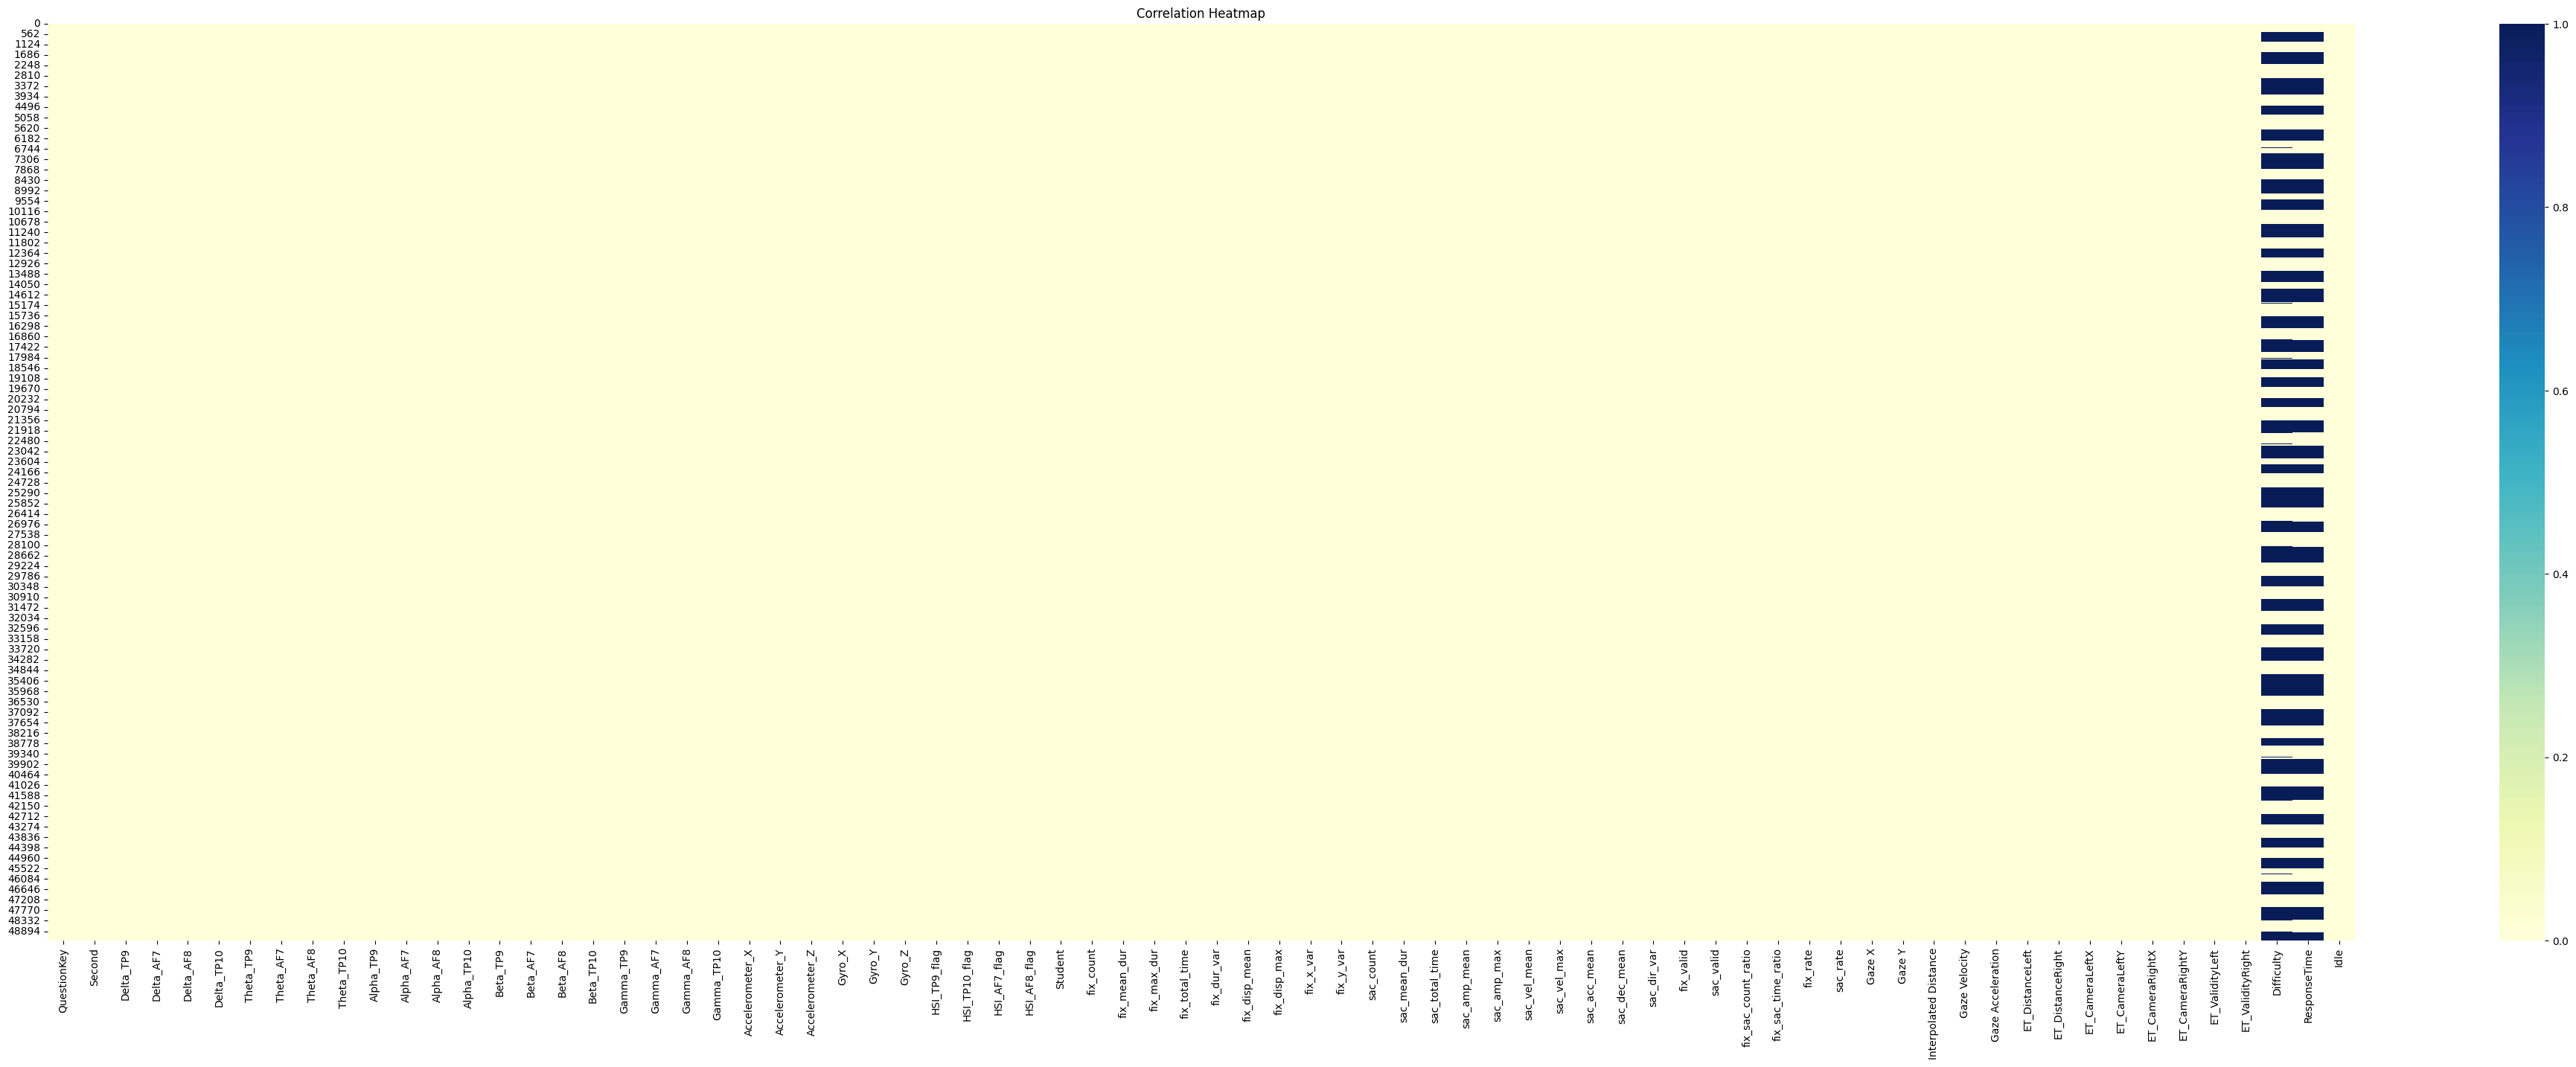

In [ ]:
plt.figure(figsize=(50, 16))
sns.heatmap(final_df.isnull(), cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
final_df['ResponseTime'] = final_df['ResponseTime'].fillna(-1)
final_df['Difficulty'] = final_df['Difficulty'].fillna(-1)

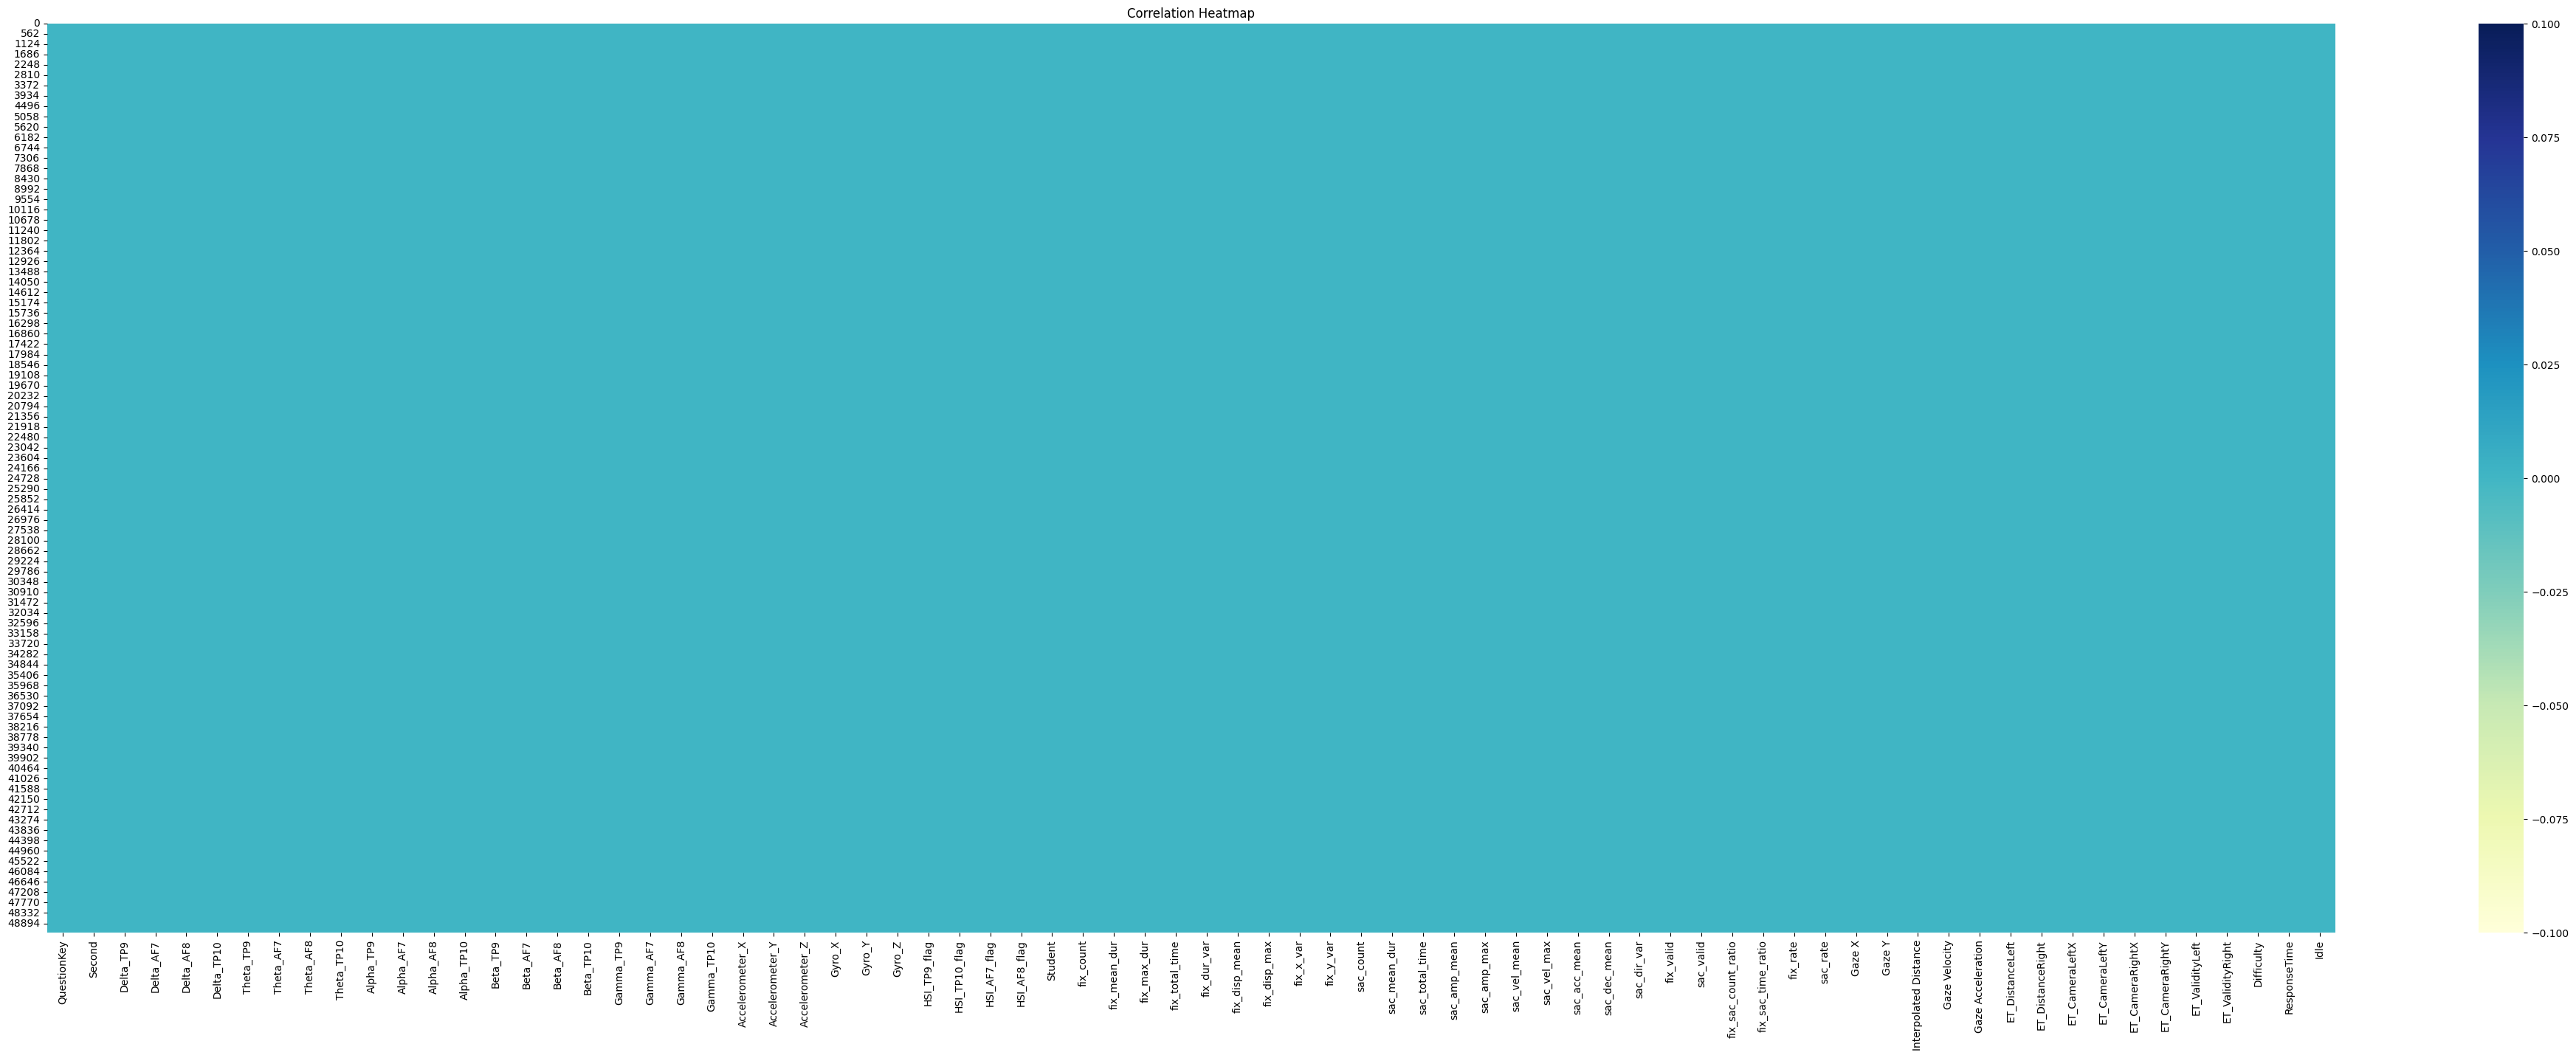

In [ ]:
plt.figure(figsize=(50, 16))
sns.heatmap(final_df.isnull(), cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Check for infinite values in the reduced DataFrame
infinite_values = final_df.isin([np.inf, -np.inf])
cols_with_infinite = infinite_values.any()

print("Columns with infinite values:")
for col, has_infinite in cols_with_infinite.items():
    if has_infinite:
        print(col)

Columns with infinite values:
Delta_TP9
Delta_AF7
Delta_TP10
Theta_TP9
Theta_AF7
Theta_TP10
Alpha_TP9
Alpha_AF7
Alpha_TP10
Beta_TP9
Beta_AF7
Beta_TP10
Gamma_TP9
Gamma_AF7
Gamma_TP10


In [ ]:
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
final_df.fillna(final_df.mean(numeric_only=True), inplace=True)

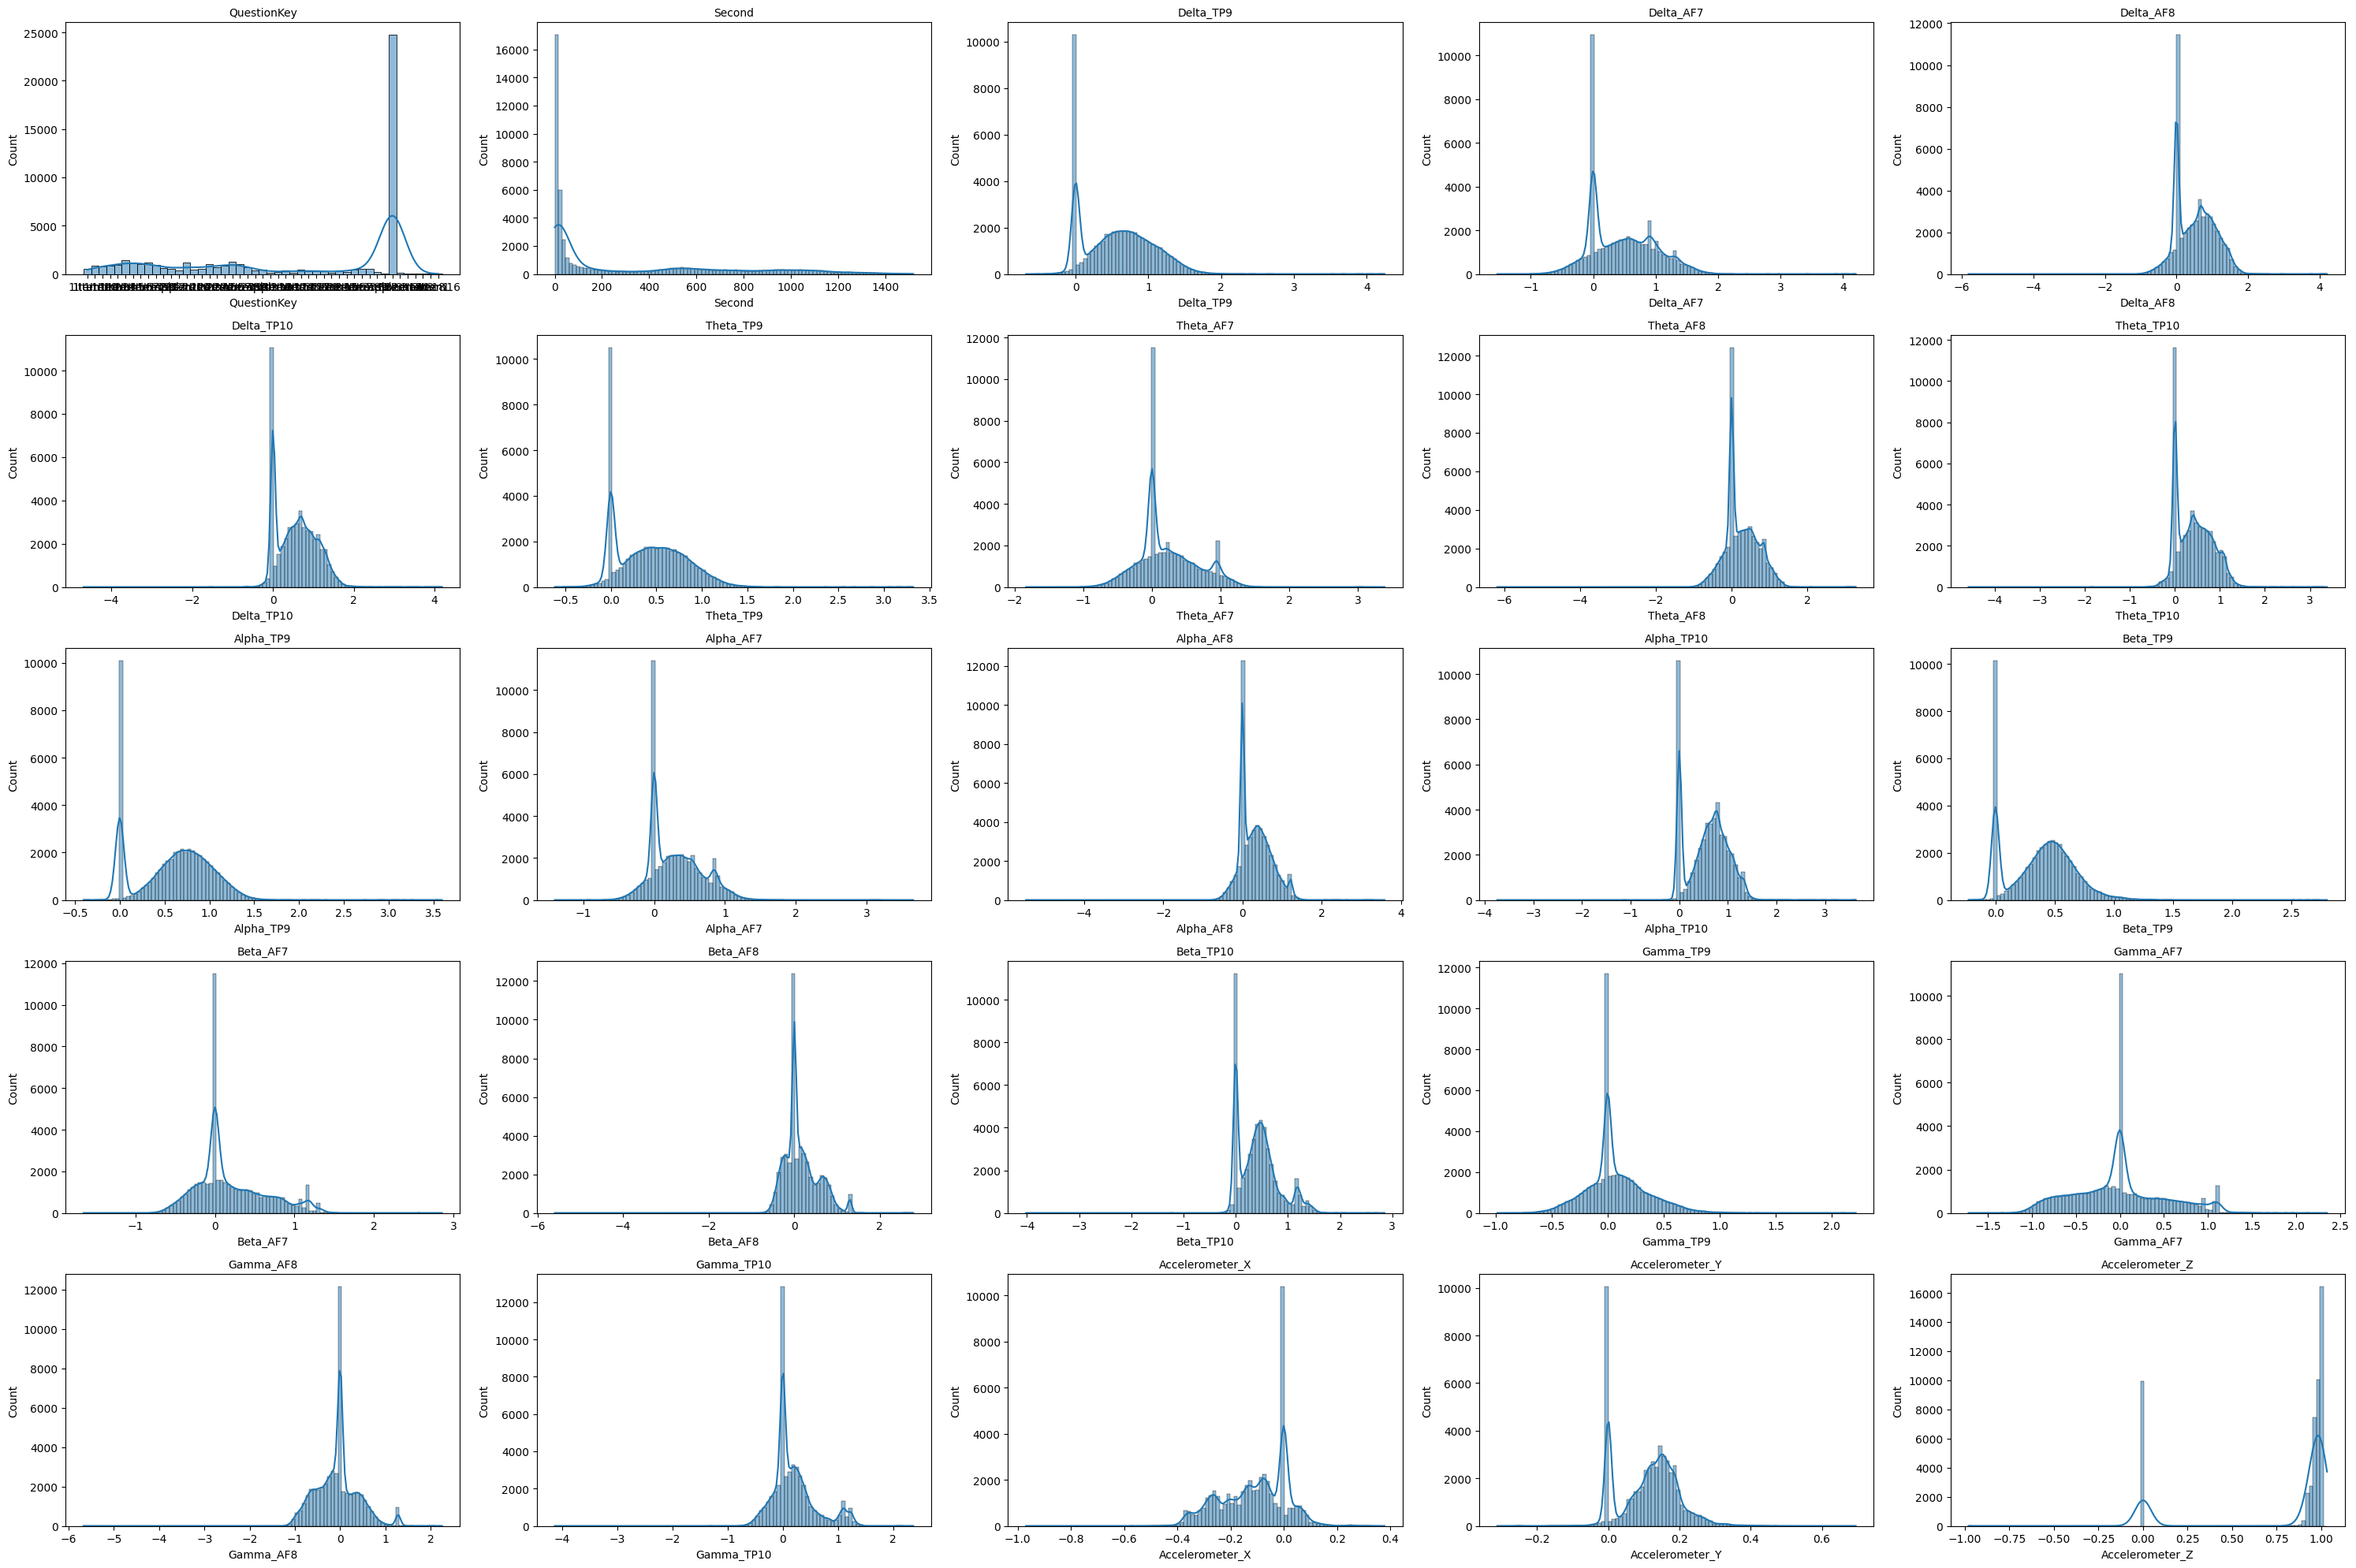

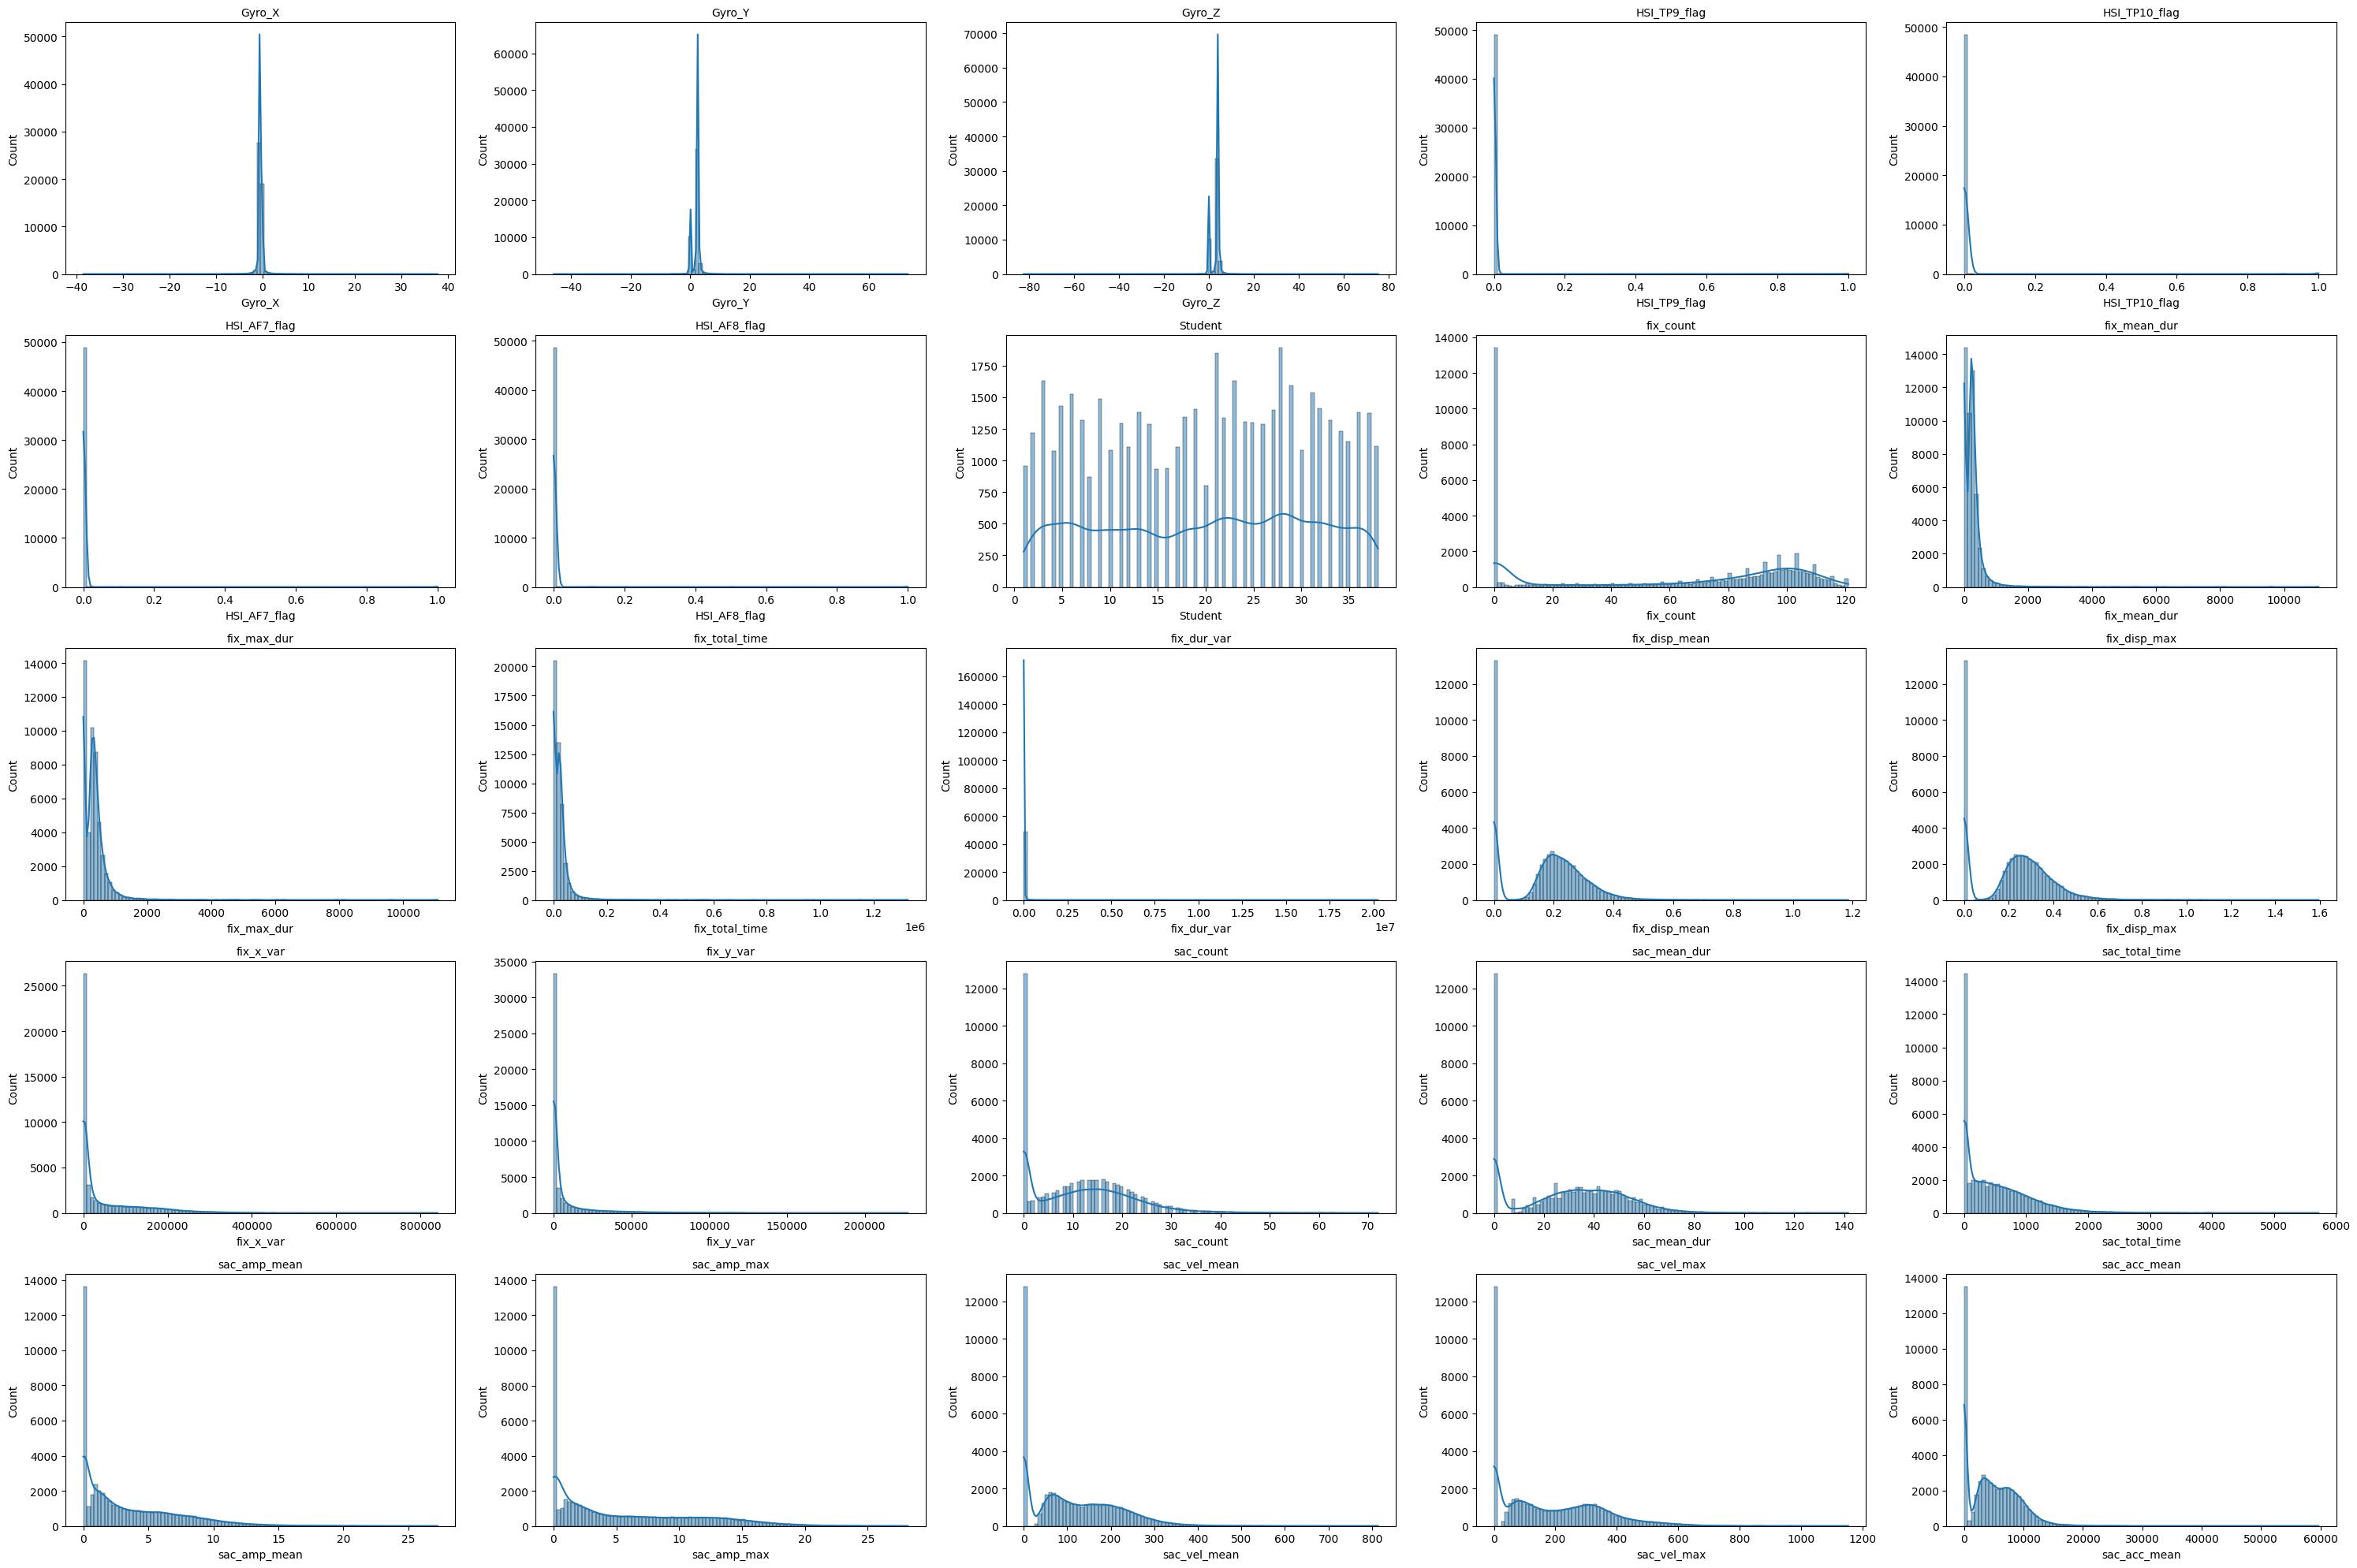

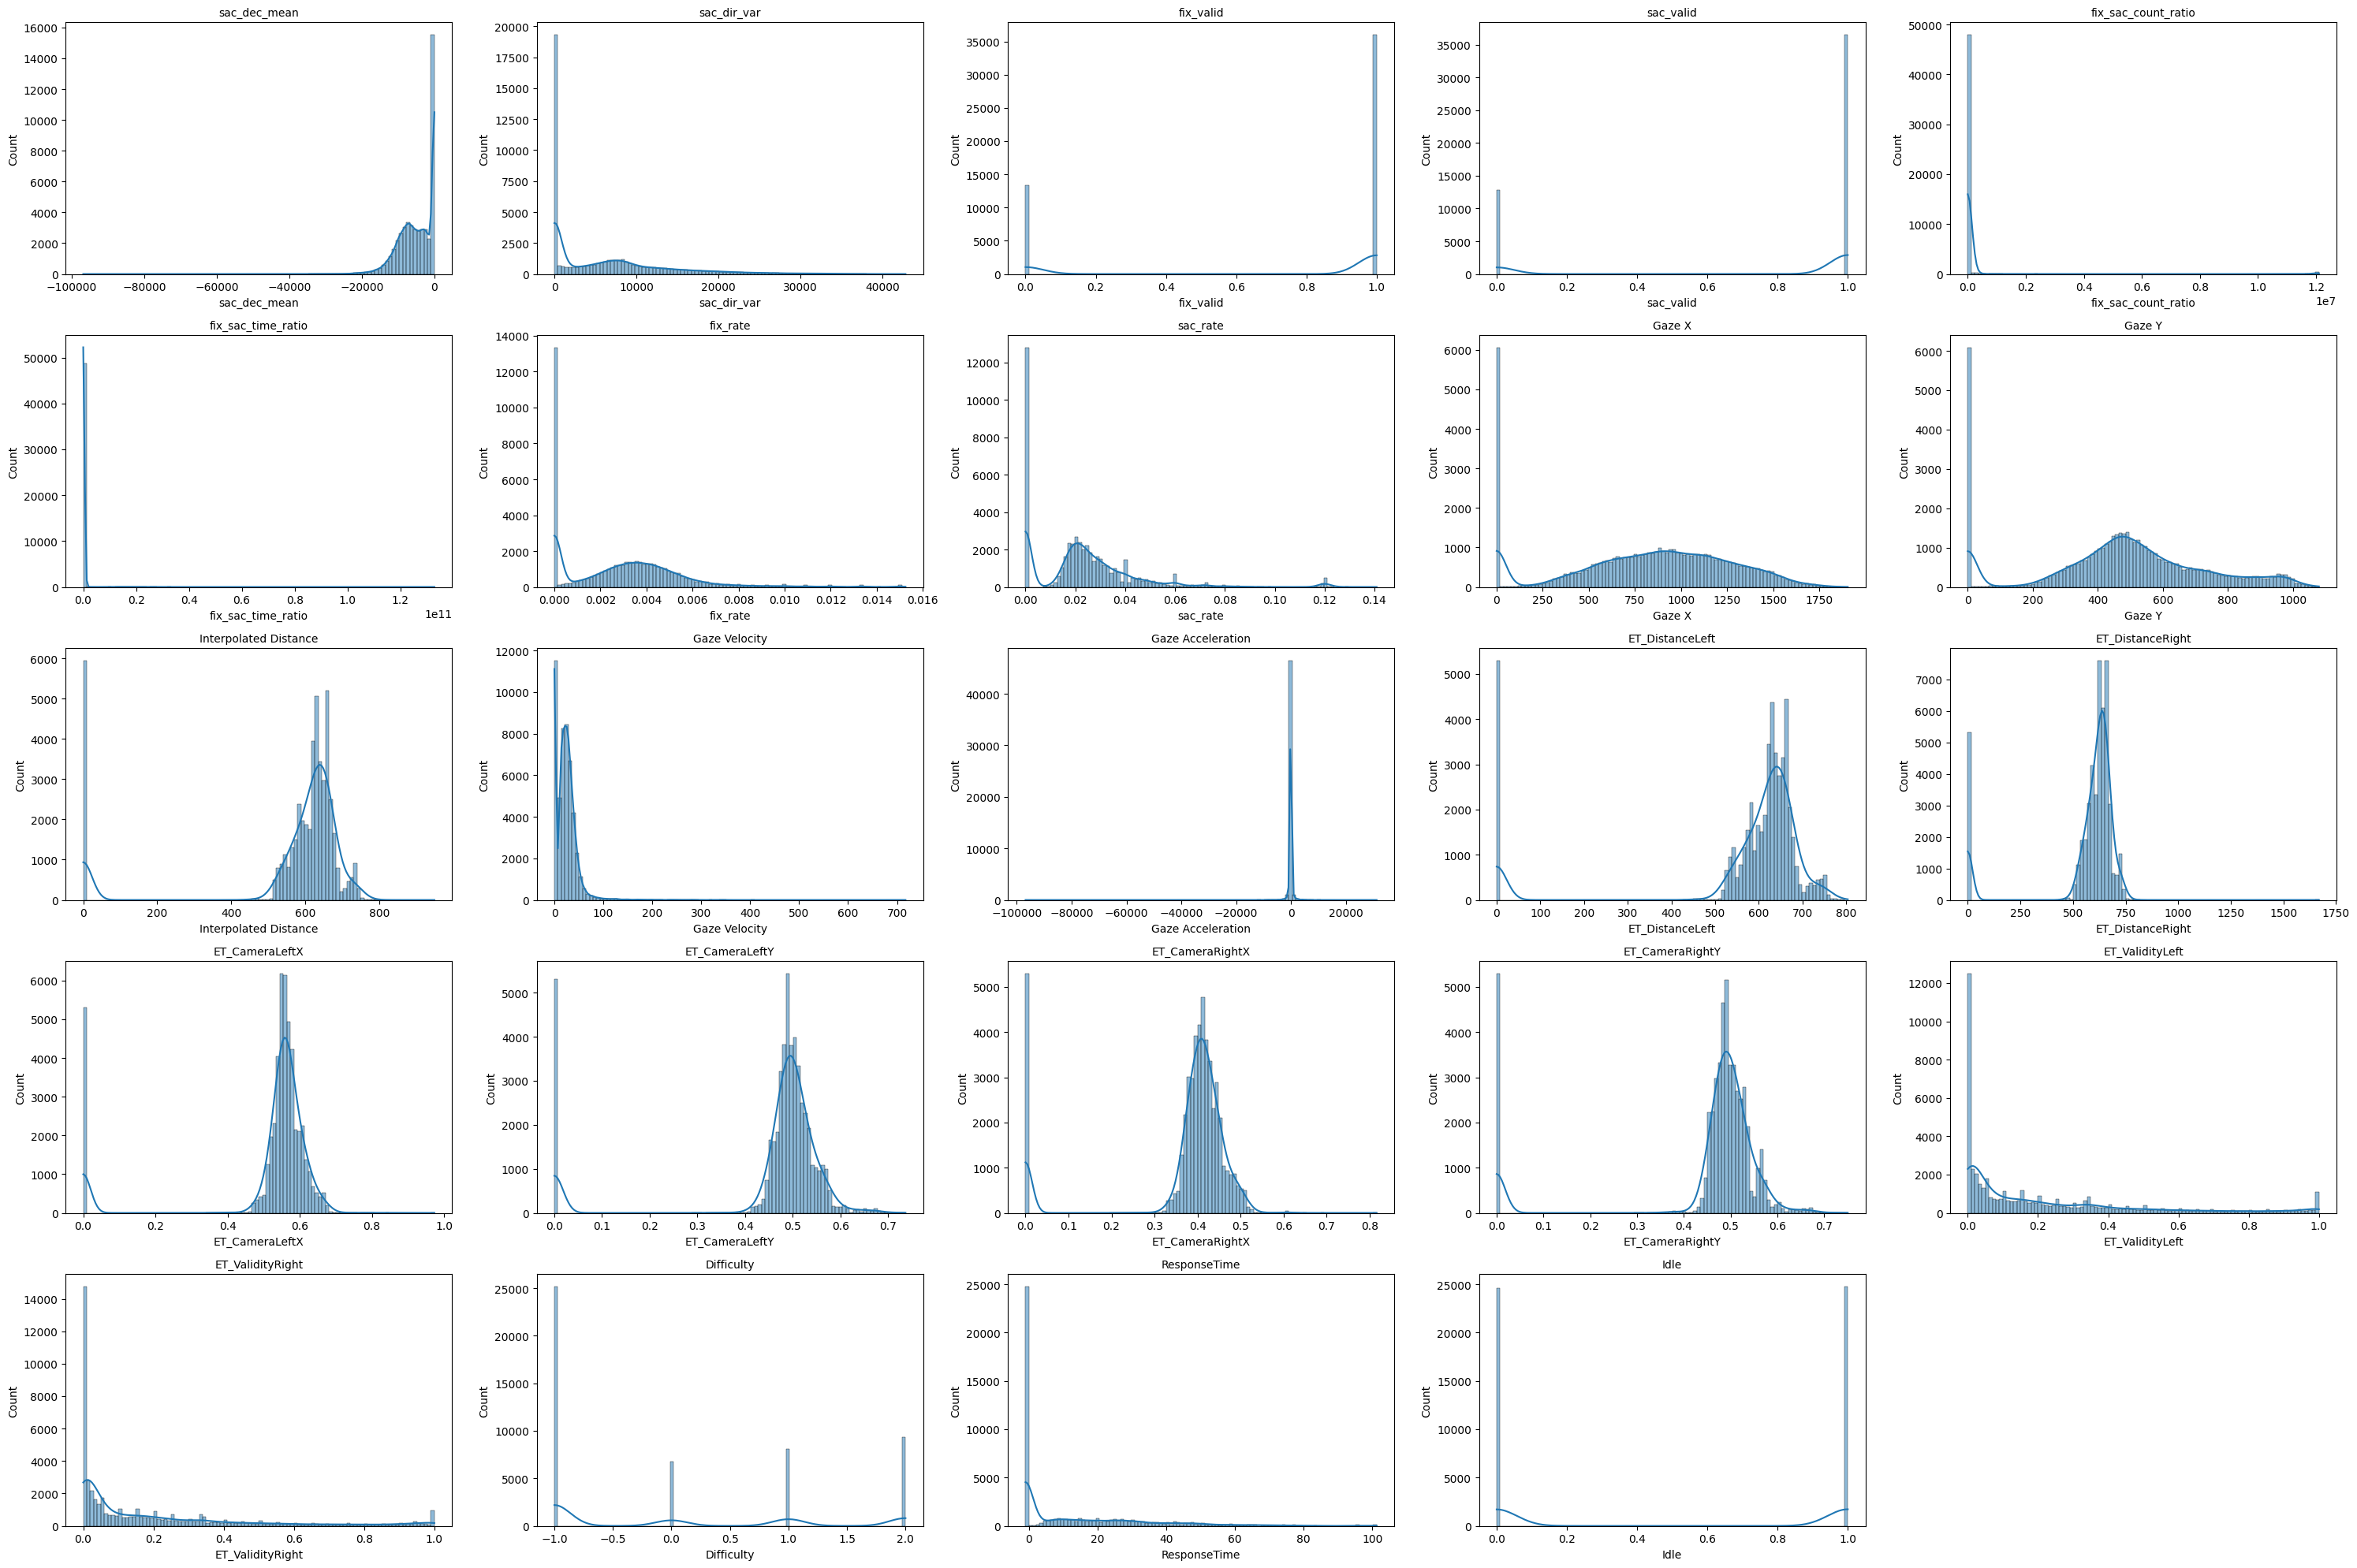

In [ ]:
columns = final_df.columns
batch_size = 25  # features per figure

for i in range(0, len(columns), batch_size):
    batch_cols = columns[i:i + batch_size]
    num_cols_batch = len(batch_cols)
    num_rows_batch = (num_cols_batch + 4) // 5  # 5 plots per row

    fig, axes = plt.subplots(num_rows_batch, 5, figsize=(30, num_rows_batch * 4))
    axes = axes.flatten()

    for j, col in enumerate(batch_cols):
        sns.histplot(data=final_df, x=col, kde=True, ax=axes[j], bins=100)  # no KDE
        axes[j].set_title(col, fontsize=10)

    # Hide unused axes
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # free memory


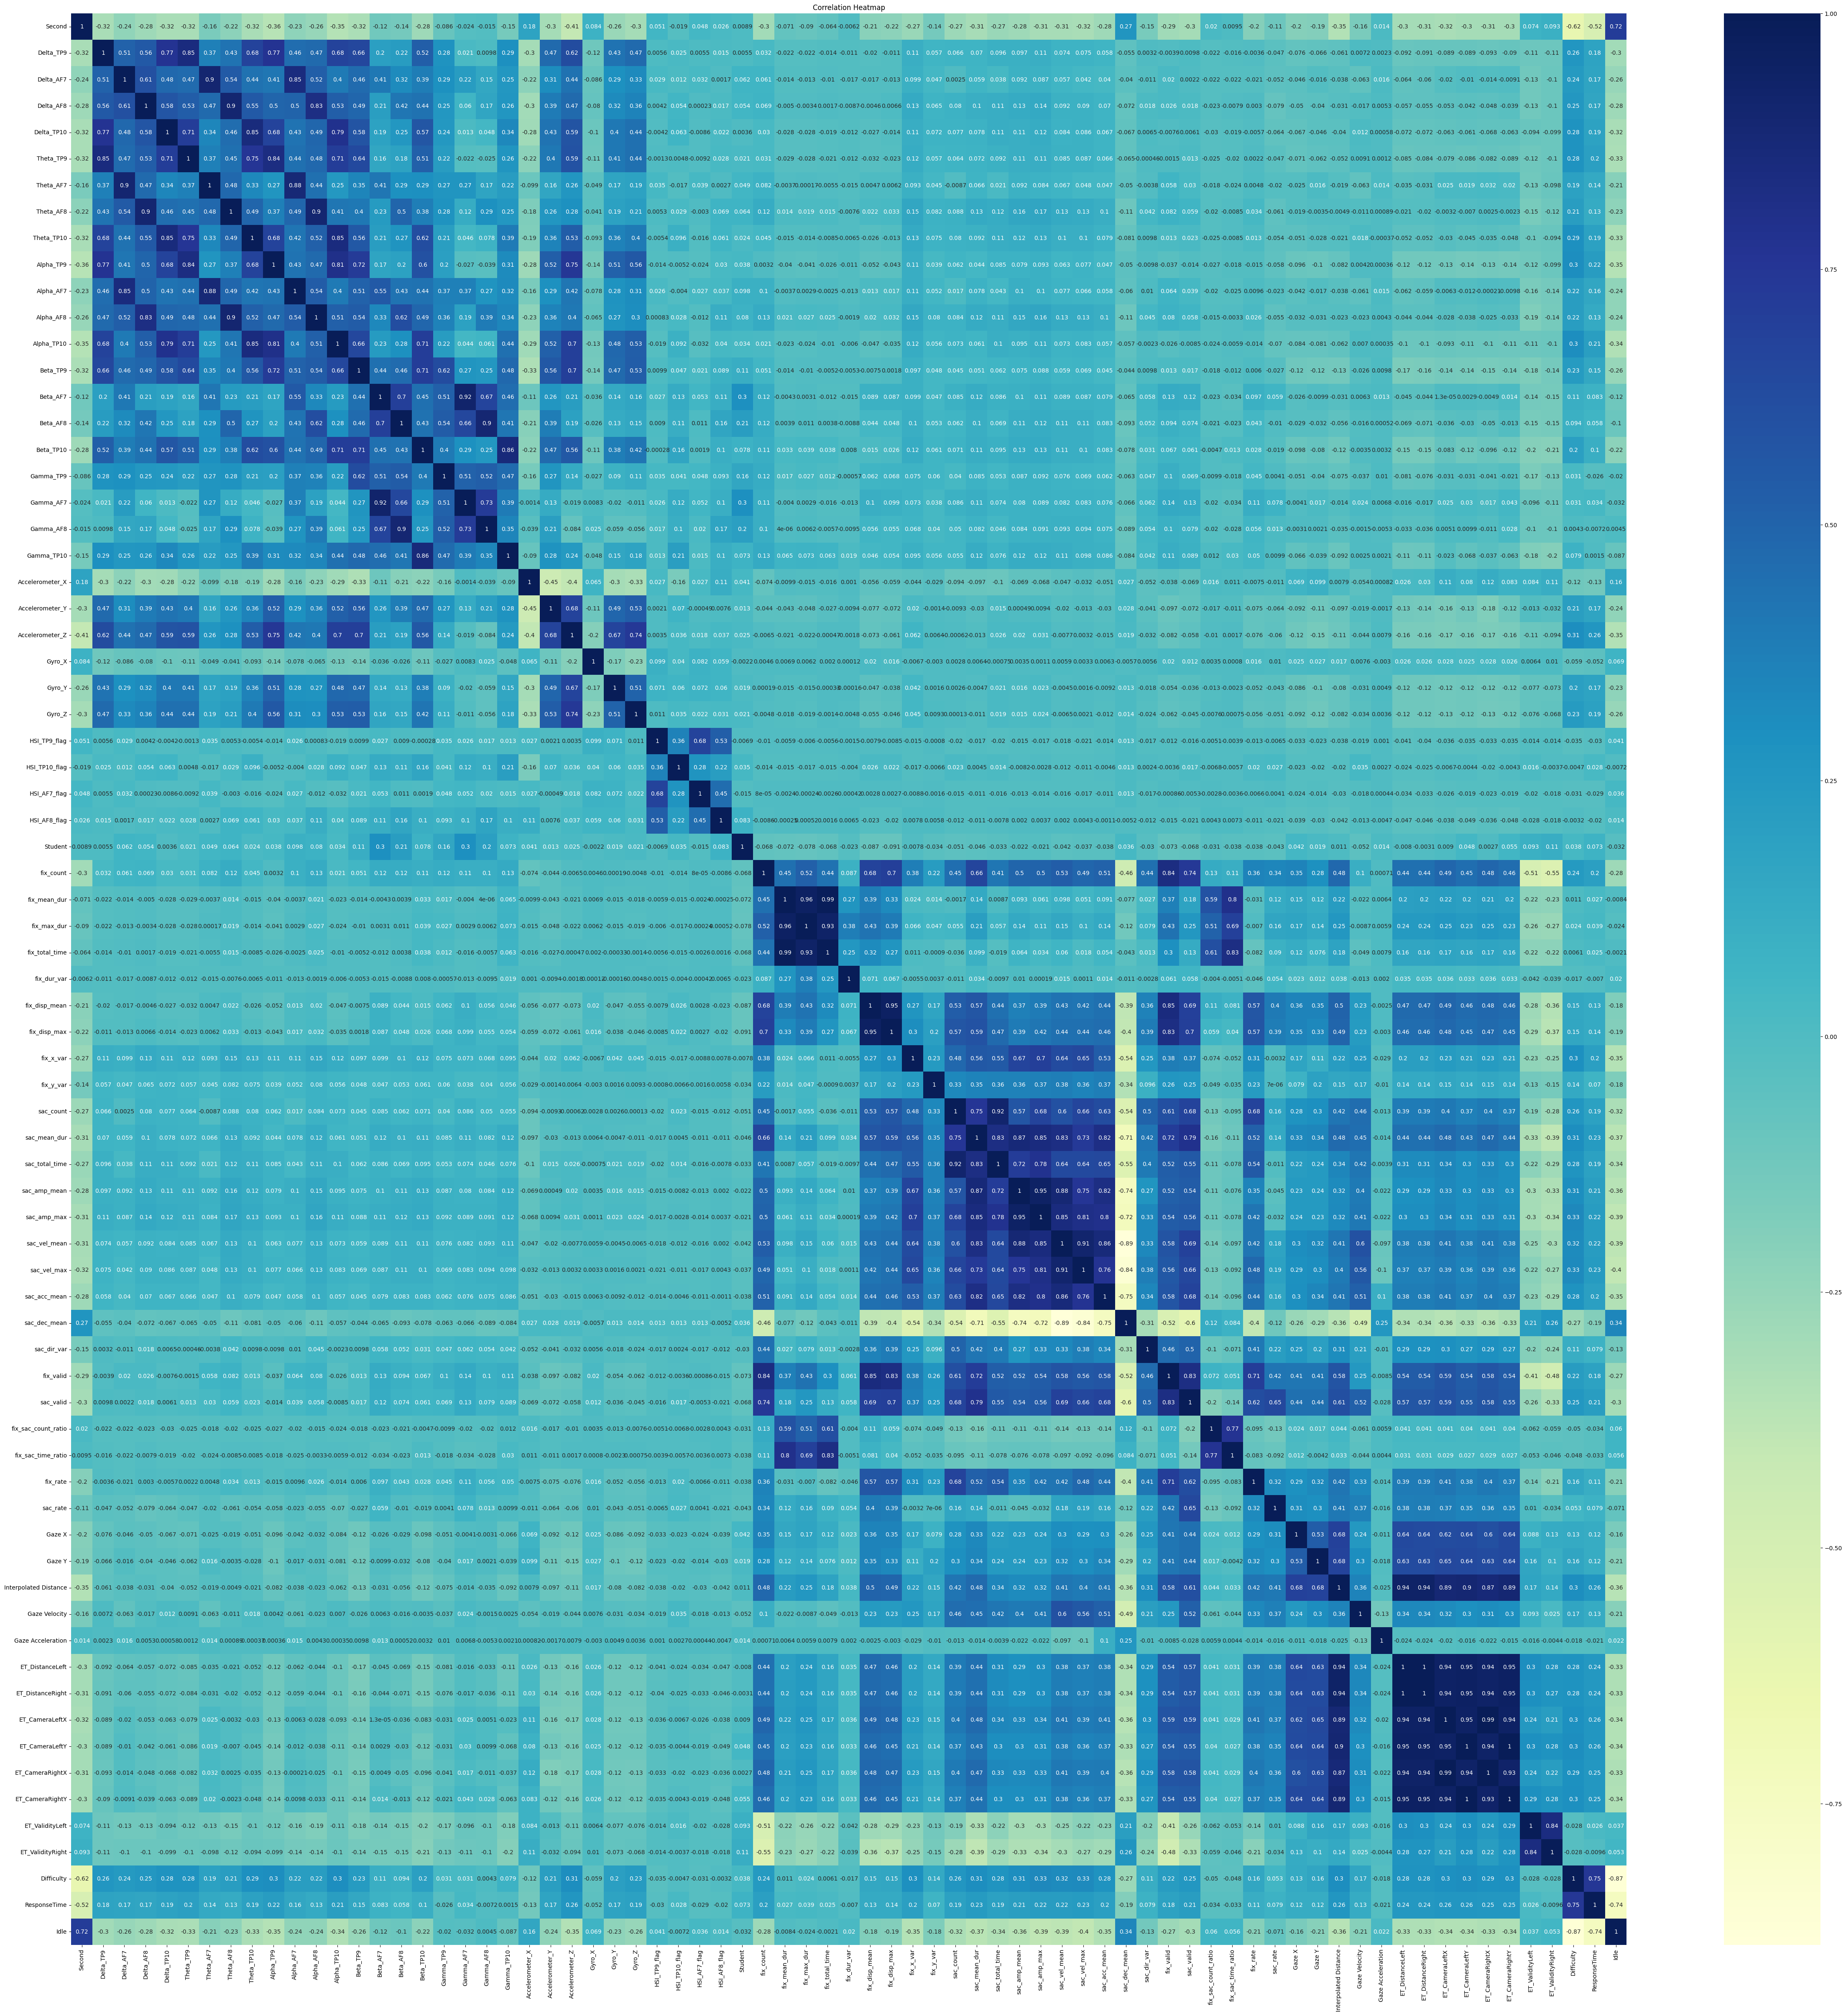

In [ ]:
plt.figure(figsize=(60, 60))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def drop_highly_correlated(df, threshold=0.9):
    # Compute correlation matrix only for numeric columns
    corr_matrix = df.corr(numeric_only=True).abs()

    # Take only upper triangle of the matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find columns to drop
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    # Return reduced DataFrame and list of dropped columns
    return df.drop(columns=to_drop), to_drop

In [ ]:
label_cols = ['ResponseTime', 'Difficulty', 'Idle', 'Student', 'QuestionKey']

In [ ]:
features = final_df.drop(columns=label_cols)

In [ ]:
reduced_features, dropped = drop_highly_correlated(features, threshold=0.9)

reduced_df = pd.concat([reduced_features, final_df[label_cols]], axis=1)

In [ ]:
reduced_df.shape

(49391, 59)

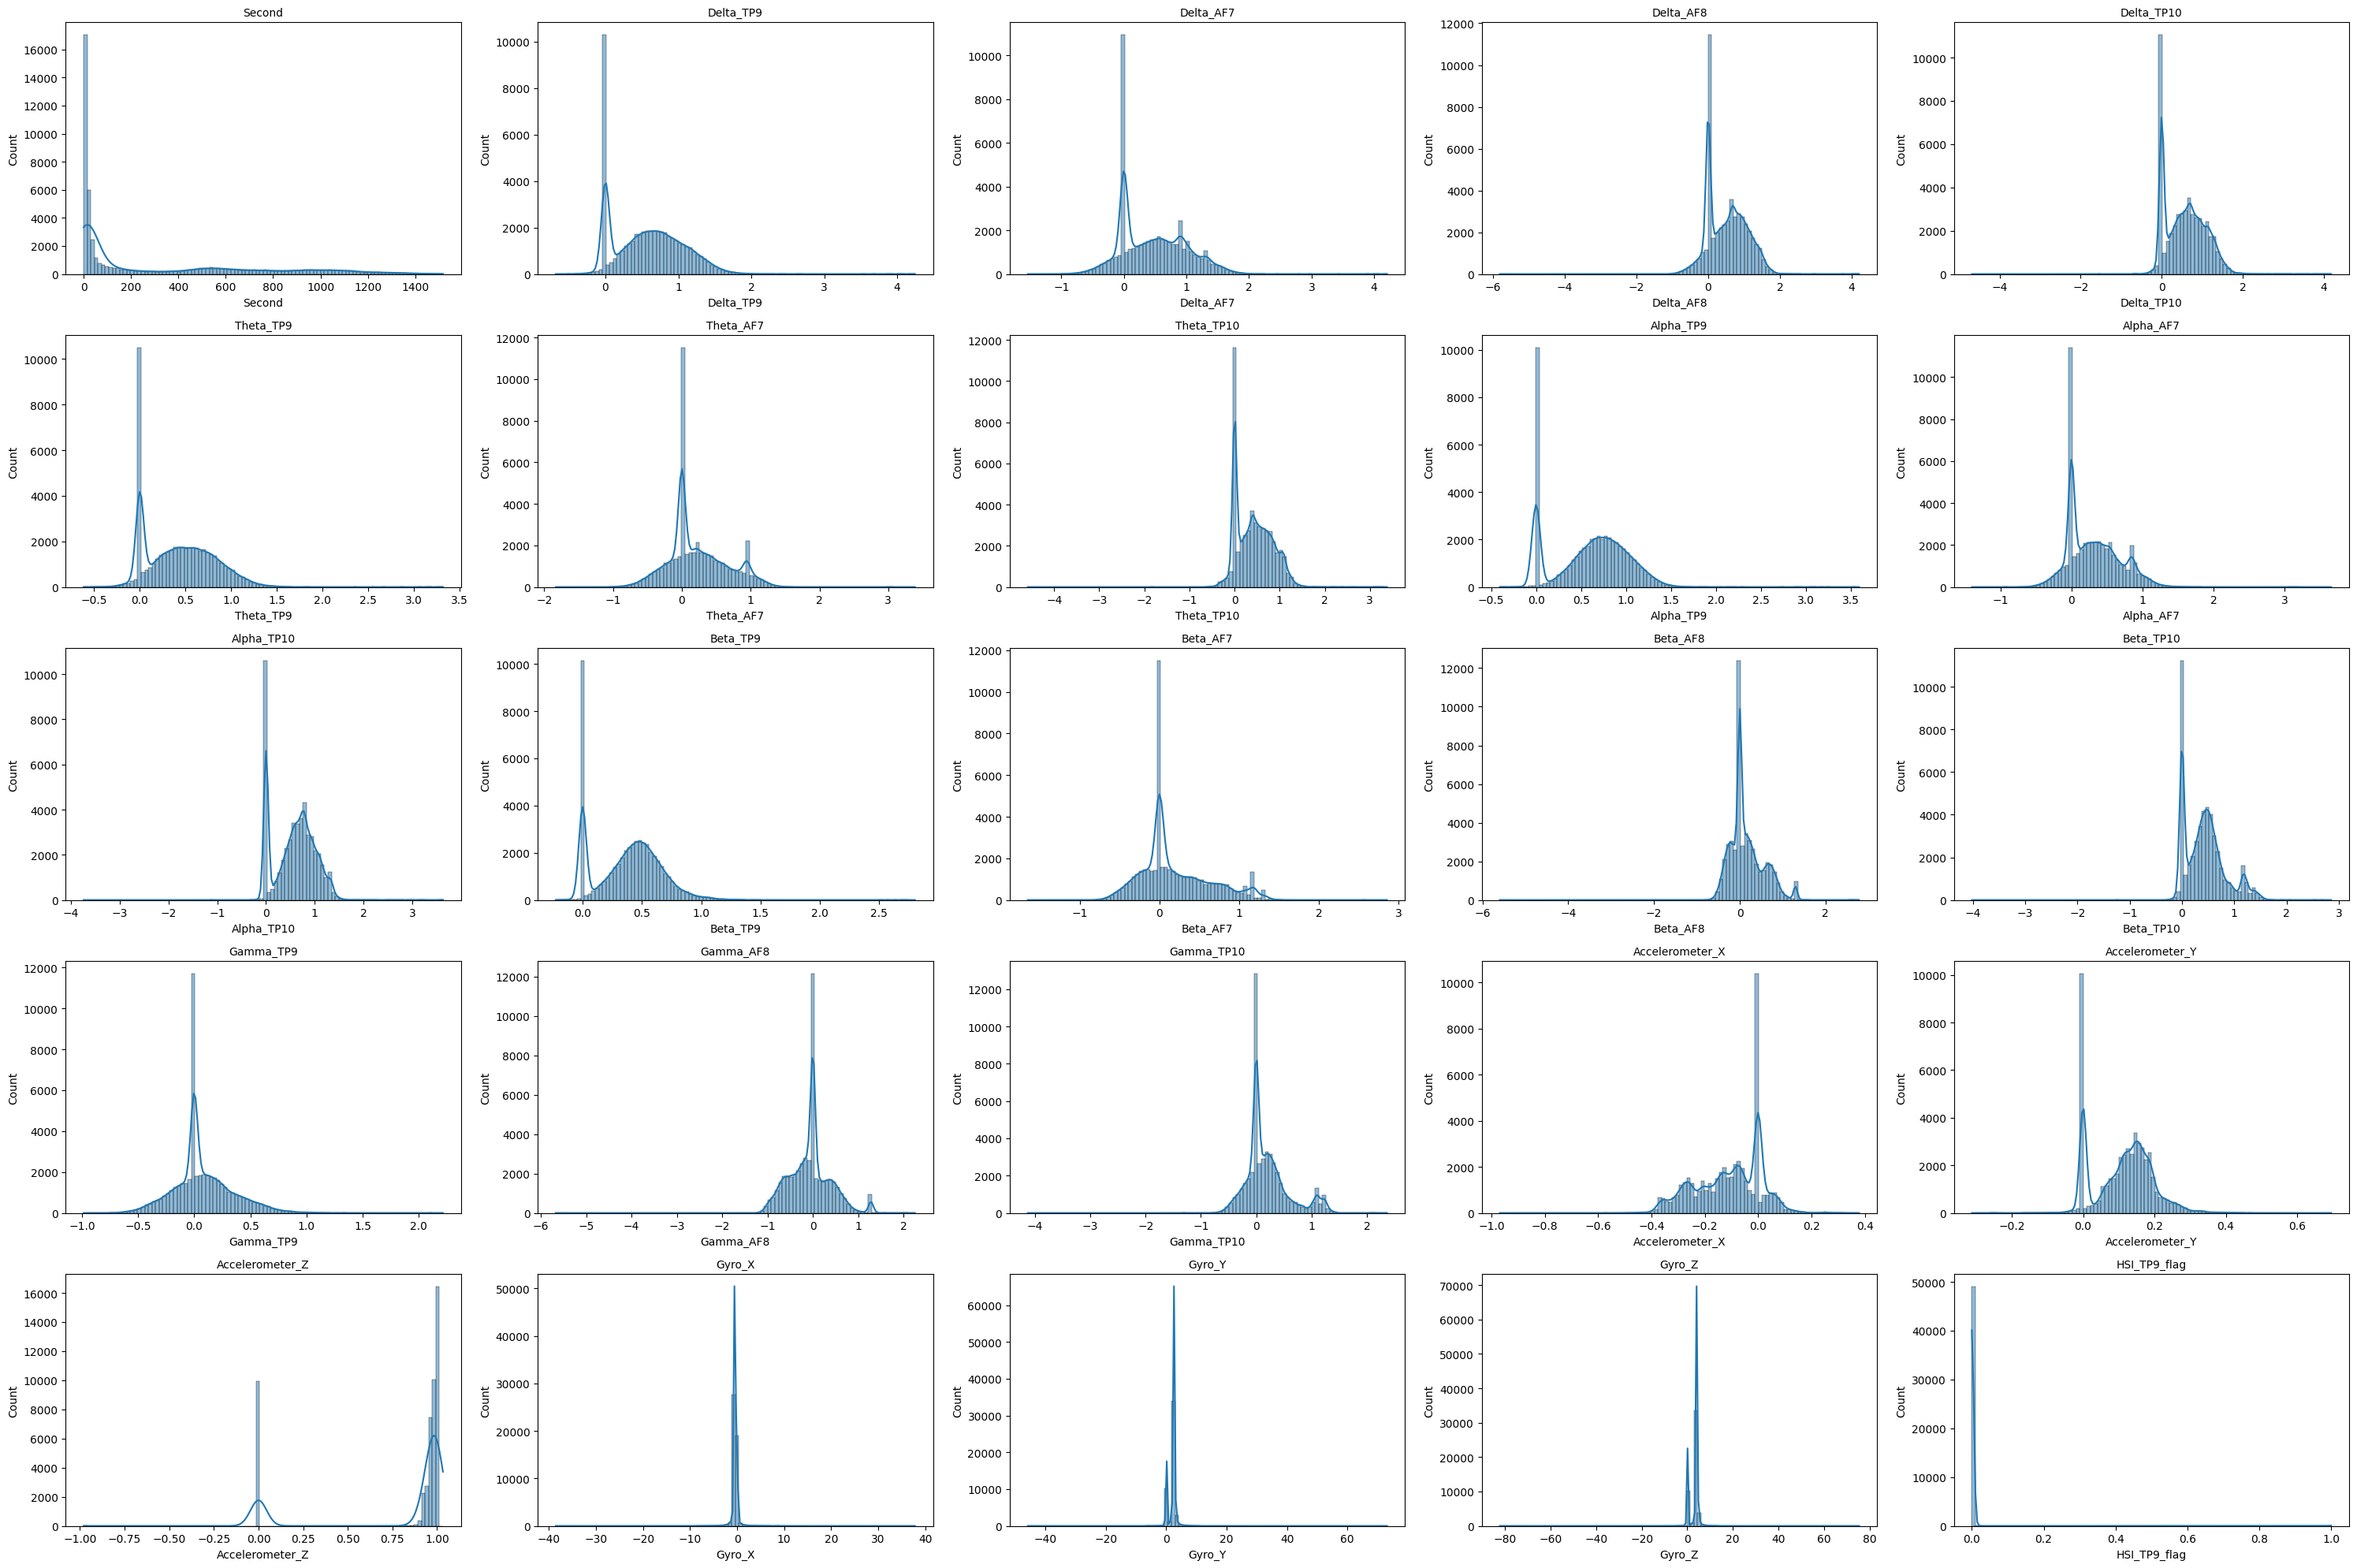

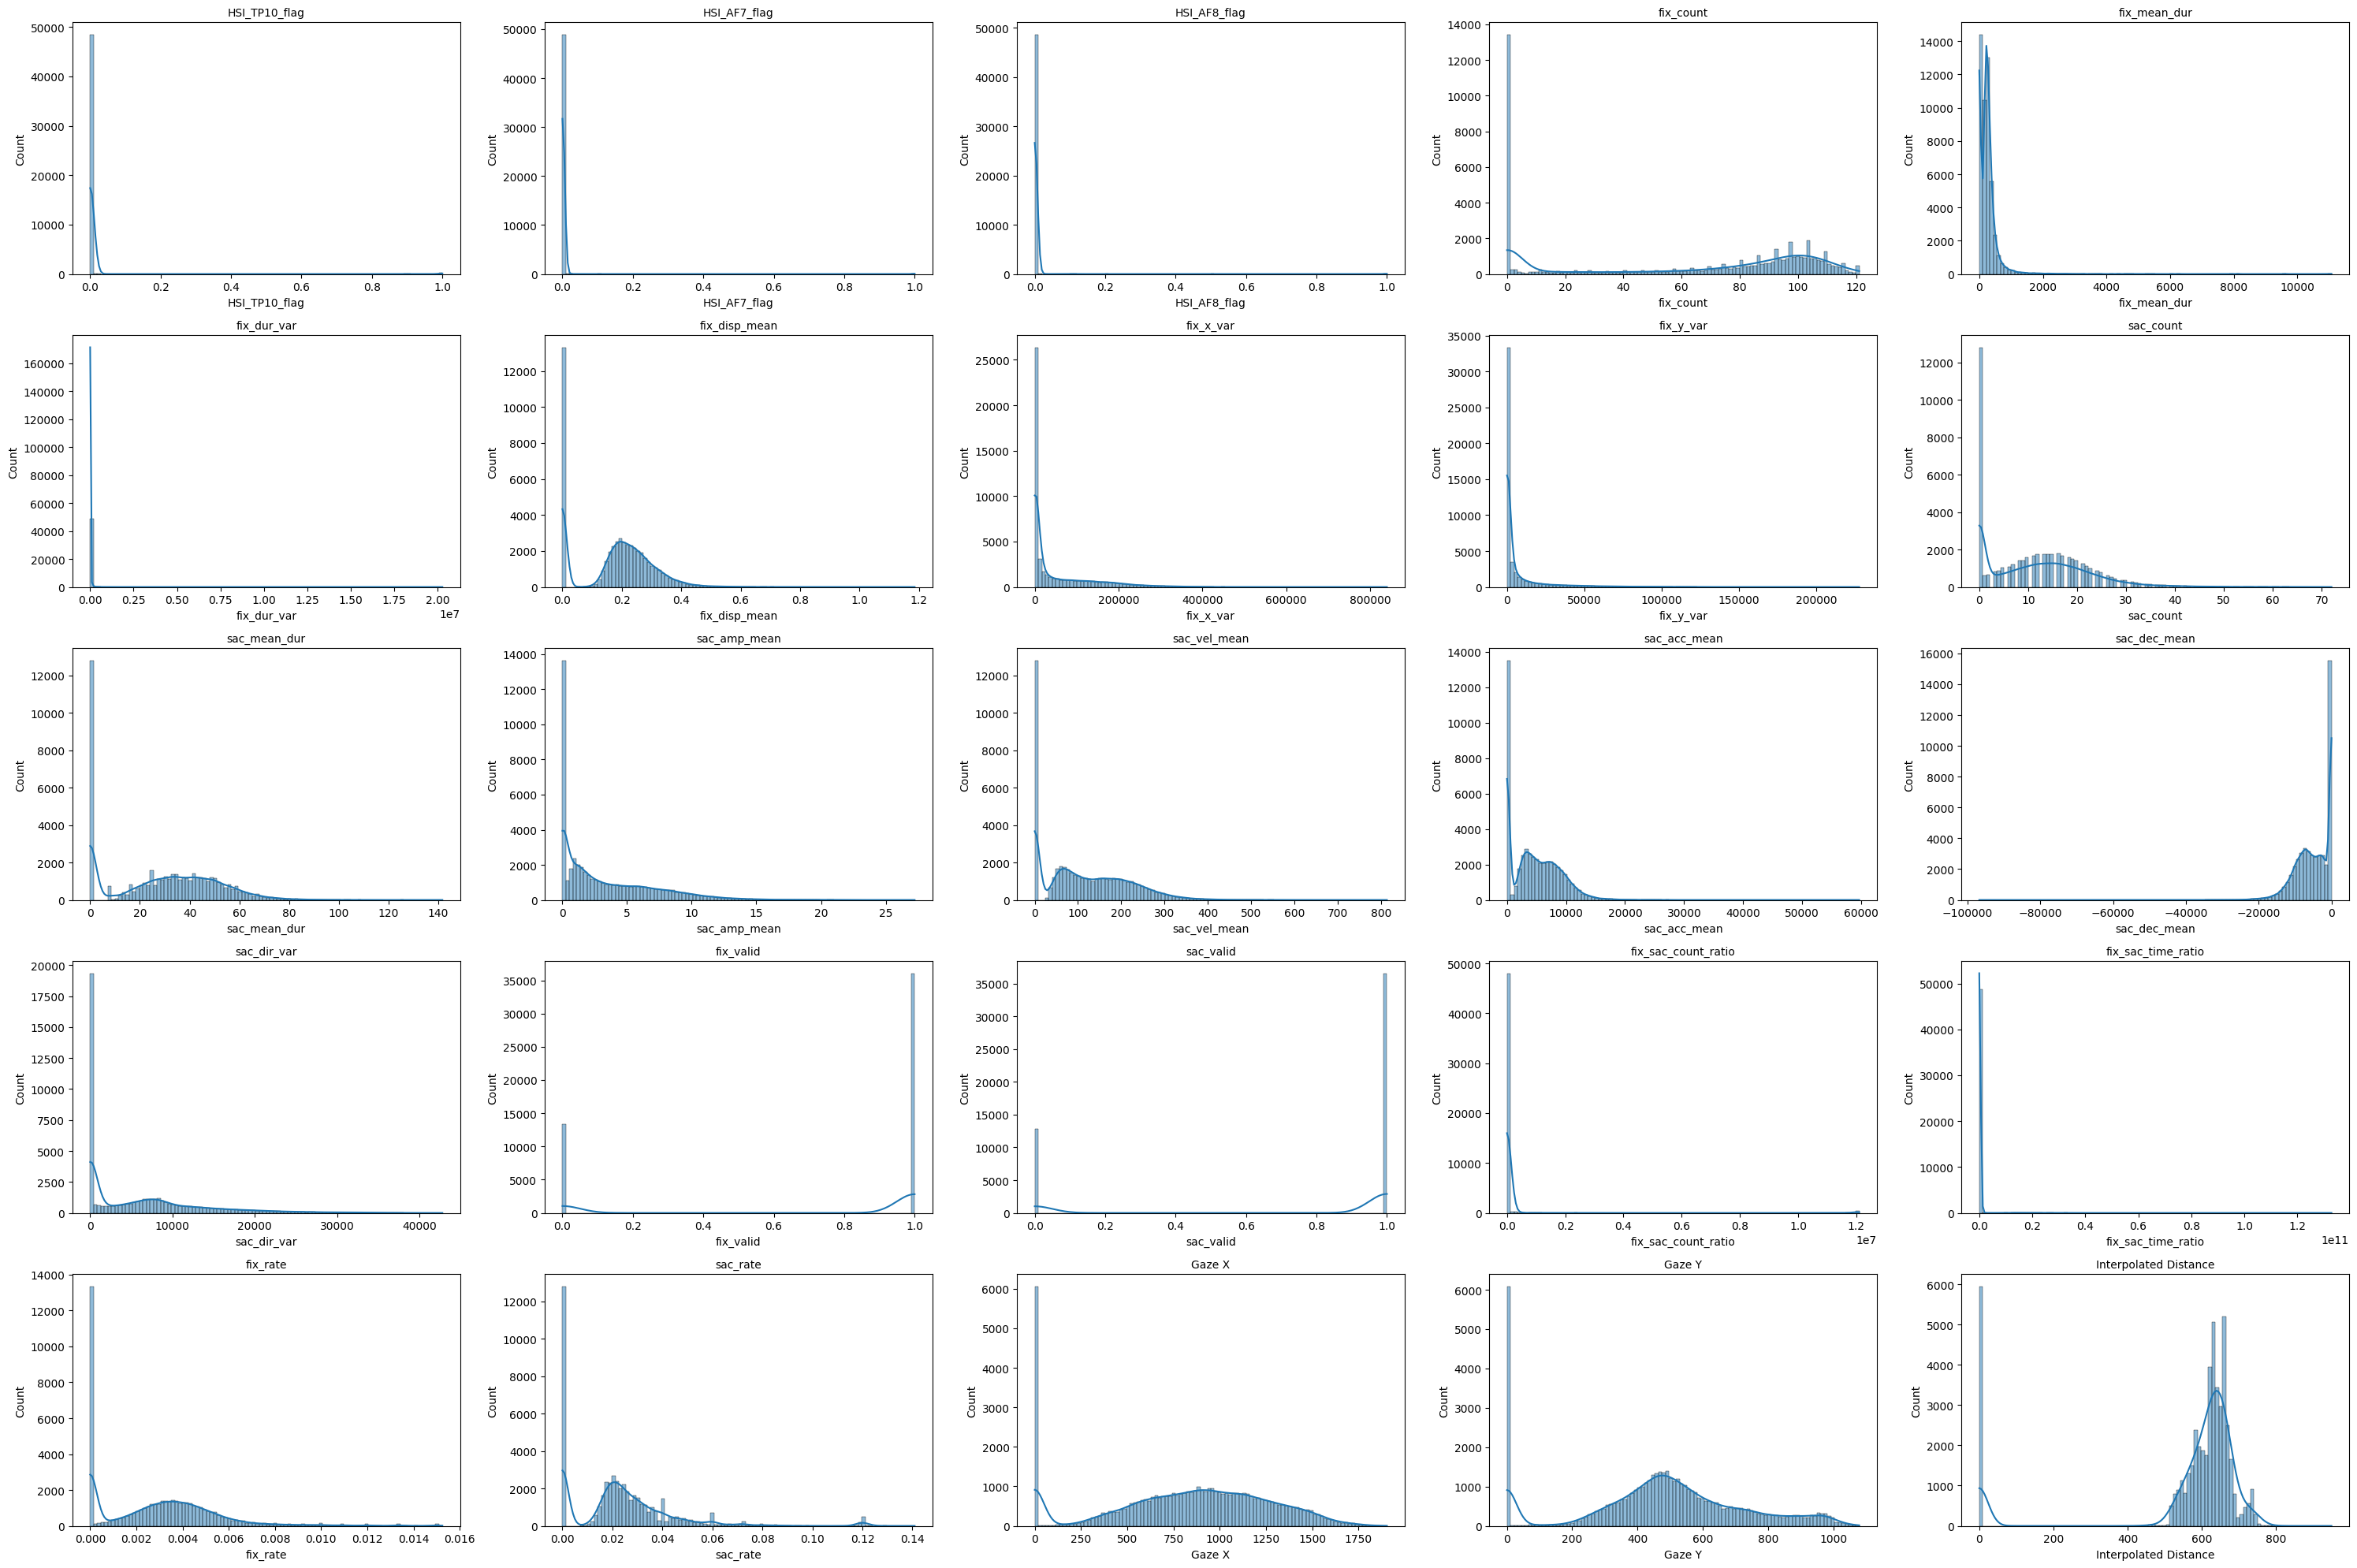

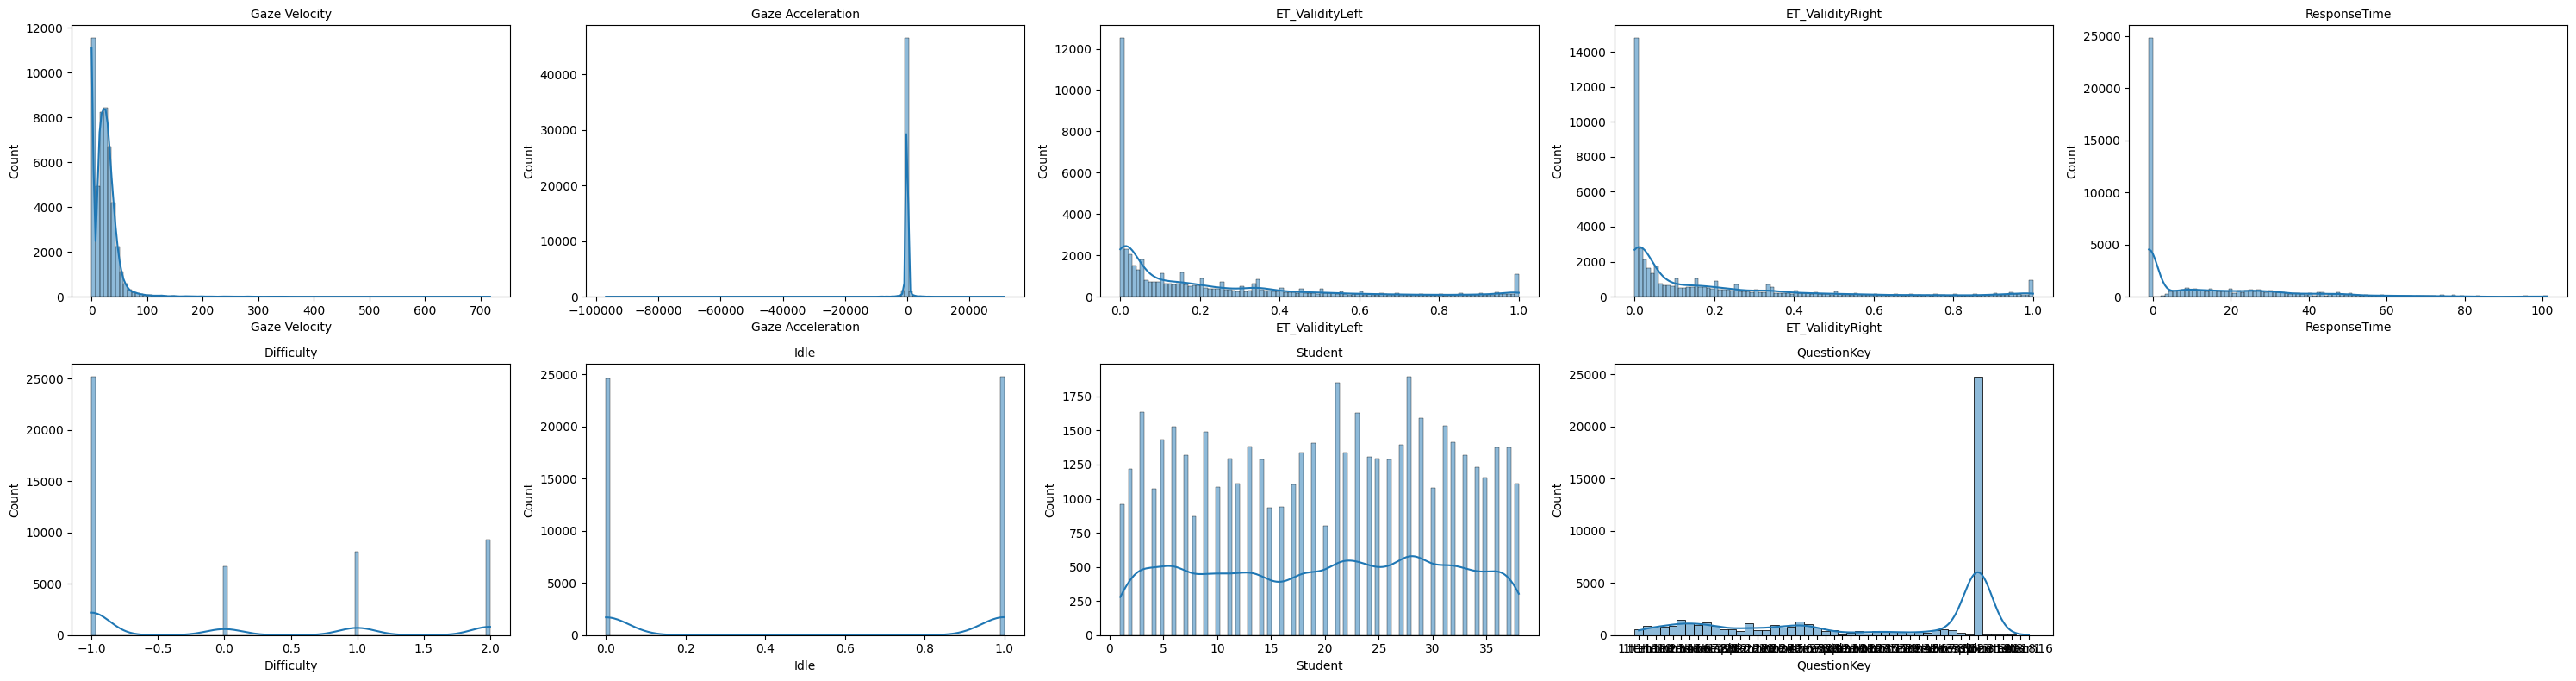

In [ ]:
columns = reduced_df.columns
batch_size = 25  # features per figure

for i in range(0, len(columns), batch_size):
    batch_cols = columns[i:i + batch_size]
    num_cols_batch = len(batch_cols)
    num_rows_batch = (num_cols_batch + 4) // 5  # 5 plots per row

    fig, axes = plt.subplots(num_rows_batch, 5, figsize=(30, num_rows_batch * 4))
    axes = axes.flatten()

    for j, col in enumerate(batch_cols):
        sns.histplot(data=reduced_df, x=col, kde=True, ax=axes[j], bins=100)  # no KDE
        axes[j].set_title(col, fontsize=10)

    # Hide unused axes
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # free memory


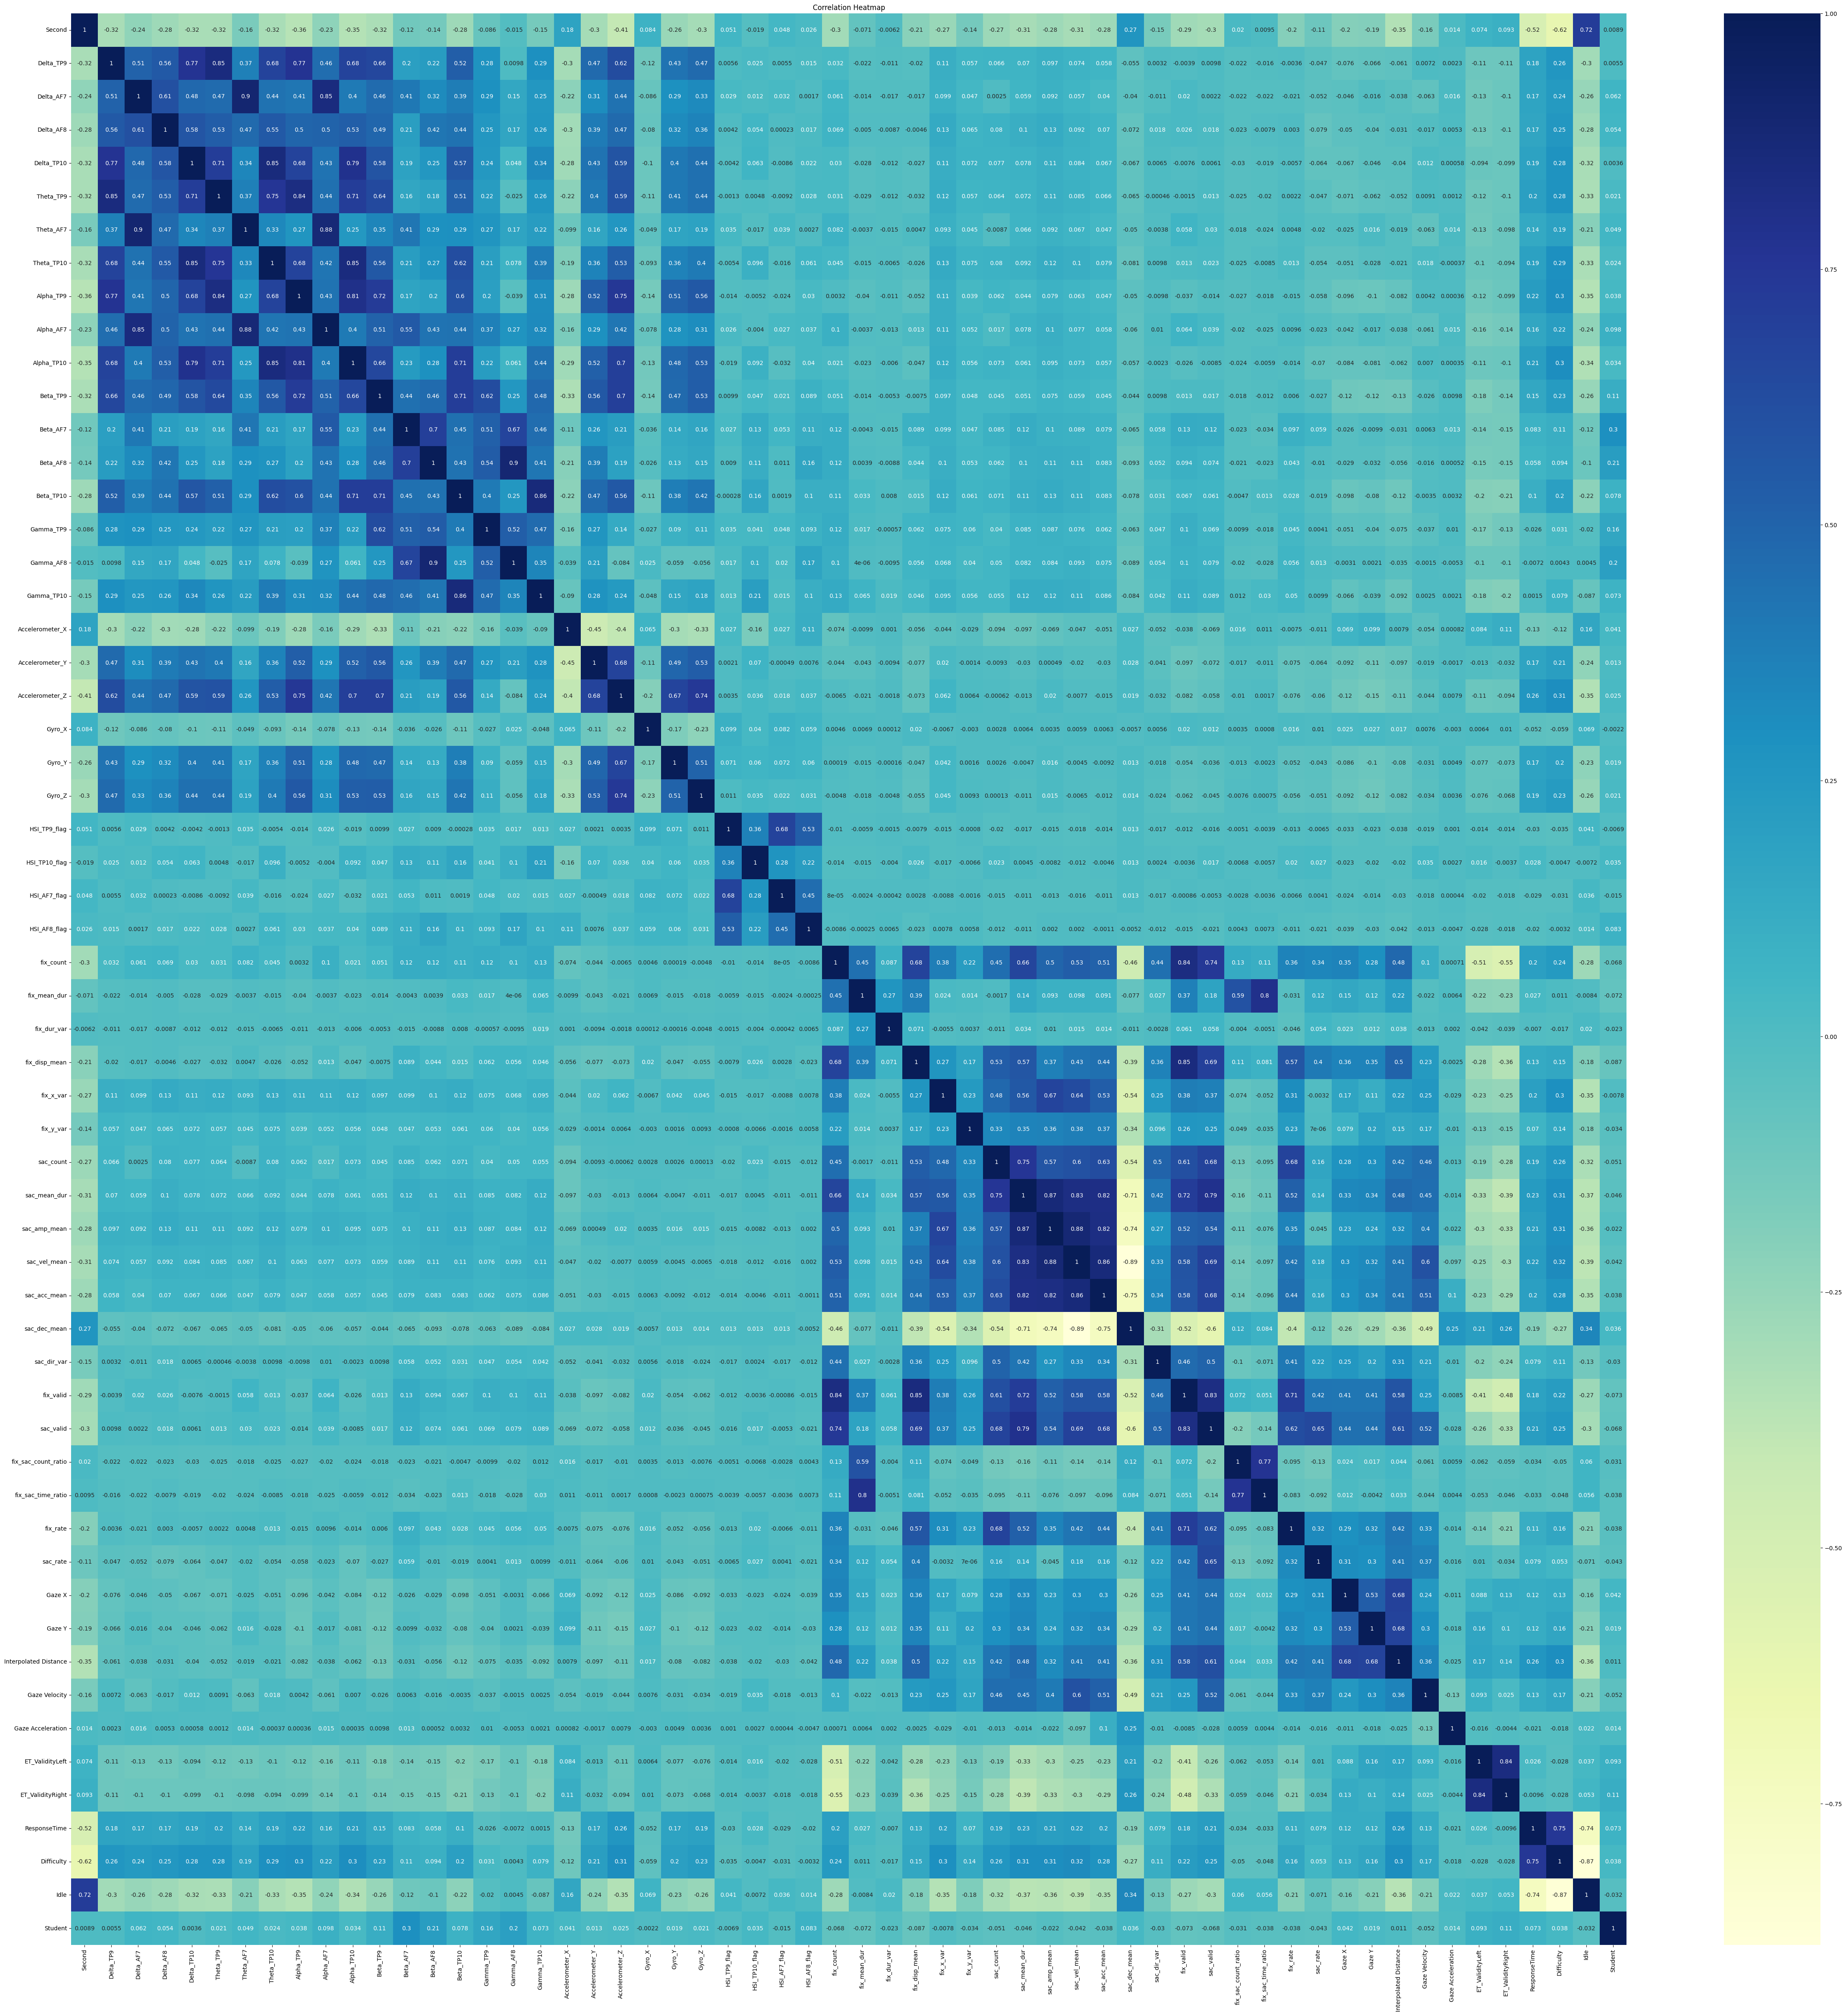

In [ ]:
plt.figure(figsize=(60, 60))
sns.heatmap(reduced_df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
reduced_df.to_csv("data/feature_engineered_data/feature_engineered_type_2.csv", index=False)